<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Objective</div>

* In this work, I will do a regression analysis on the CYGNSS and SMAP Soil Moisture Data for the year 2019, 2020 and 2021
* We will be considered boostings XGBoost, Light GBM and CatBoost algorithm for which we will tuning hyperparameters

<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Library import & Dataset </div>

In [1]:
import warnings
warnings.filterwarnings('ignore')  # ignore notifications

In [2]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

## Data Preparation
+ Combining the CYGNSS features with SMAP soil moisture 
+ Resampling CYGNSS into 36 km grid cell of SMAP
+ Combining 2019, 2020 and 2021 data for each grid cell

In [3]:
# import Data_CYGNSS_SM_for_Arema_Sarima_XGBoost
# import imp
# imp.reload(Data_CYGNSS_SM_for_Arema_Sarima_XGBoost)
# import Data_CYGNSS_SM_for_Arema_Sarima_XGBoost as SC1

# lat = [22.18,22.54,22.9,23.26,23.62,23.98,24.34,24.7,25.06,25.42,25.78,26.14,26.5,26.86] 
# lon = [73.18,73.54,73.9,74.26,74.98,75.34,75.7,76.06,76.42,76.78,77.14,77.5,77.86,78.22,78.58,78.94]
# for i in range(len(lat)):
#     for j in range(len(lon)):
#         DF = SC1.Concat(lat[i],lon[j])

## Loading data for a single grid cell

In [4]:
lat = 22.9
lon = 77.86
Data = pd.read_csv(rf'D:\EG\Project Data\ML_Model_Datasets\CYGNSS_SMAP_2019_21_{lat}_{lon}.csv')

In [5]:
Data.corr()

,sp_inc_angle,sp_rx_gain,gps_tx_power_db_w,gps_ant_gain_db_i,ddm_snr,ddm_noise_floor,rx_to_sp_range,tx_to_sp_range,quality_flags,peak of power_analog,SR_eff,SMAP_Soil_Moisture
sp_inc_angle,1.000000,0.134994,-0.157698,0.643323,0.071978,-0.014731,0.942643,0.874560,-0.030141,0.065936,0.012203,-0.061396
sp_rx_gain,0.134994,1.000000,0.013146,0.070254,0.489221,0.302790,0.118335,0.124722,-0.006748,0.473518,-0.050070,-0.101276
gps_tx_power_db_w,-0.157698,0.013146,1.000000,0.003568,0.127552,-0.005990,-0.120013,-0.281401,-0.003091,0.103116,-0.018973,-0.023592
gps_ant_gain_db_i,0.643323,0.070254,0.003568,1.000000,0.080187,-0.028845,0.743196,0.581460,-0.043567,0.071622,0.015545,-0.058630
ddm_snr,0.071978,0.489221,0.127552,0.080187,1.000000,-0.040296,0.077621,0.055615,0.011310,0.875443,0.674749,0.262345
ddm_noise_floor,-0.014731,0.302790,-0.005990,-0.028845,-0.040296,1.000000,-0.021037,0.005258,0.095357,-0.022986,-0.182497,-0.169157
rx_to_sp_range,0.942643,0.118335,-0.120013,0.743196,0.077621,-0.021037,1.000000,0.858604,-0.035816,0.059123,0.001986,-0.054284
tx_to_sp_range,0.874560,0.124722,-0.281401,0.581460,0.055615,0.005258,0.858604,1.000000,-0.043387,0.030744,-0.010185,-0.067007
quality_flags,-0.030141,-0.006748,-0.003091,-0.043567,0.011310,0.095357,-0.035816,-0.043387,1.000000,0.014729,0.023236,0.004881
peak of power_analog,0.065936,0.473518,0.103116,0.071622,0.875443,-0.022986,0.059123,0.030744,0.014729,1.000000,0.781019,0.265918


In [6]:
Data.keys()

Index(['sp_inc_angle', 'sp_rx_gain', 'gps_tx_power_db_w', 'gps_ant_gain_db_i',
       'ddm_snr', 'ddm_noise_floor', 'rx_to_sp_range', 'tx_to_sp_range',
       'quality_flags', 'peak of power_analog', 'SR_eff', 'Date',
       'SMAP_Soil_Moisture'],
      dtype='object')

<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">  Data preprocessing </div>

In [7]:
print(f'DataFrame size: {Data.shape}')

DataFrame size: (1096, 13)


In [8]:
print(f'Number of missing values in DataFrame:\n{Data.isna().sum()}')

Number of missing values in DataFrame:
sp_inc_angle            464
sp_rx_gain              464
gps_tx_power_db_w       464
gps_ant_gain_db_i       464
ddm_snr                 464
ddm_noise_floor         464
rx_to_sp_range          464
tx_to_sp_range          464
quality_flags           464
peak of power_analog    464
SR_eff                  464
Date                      0
SMAP_Soil_Moisture      153
dtype: int64


## Time series of soil moisture data

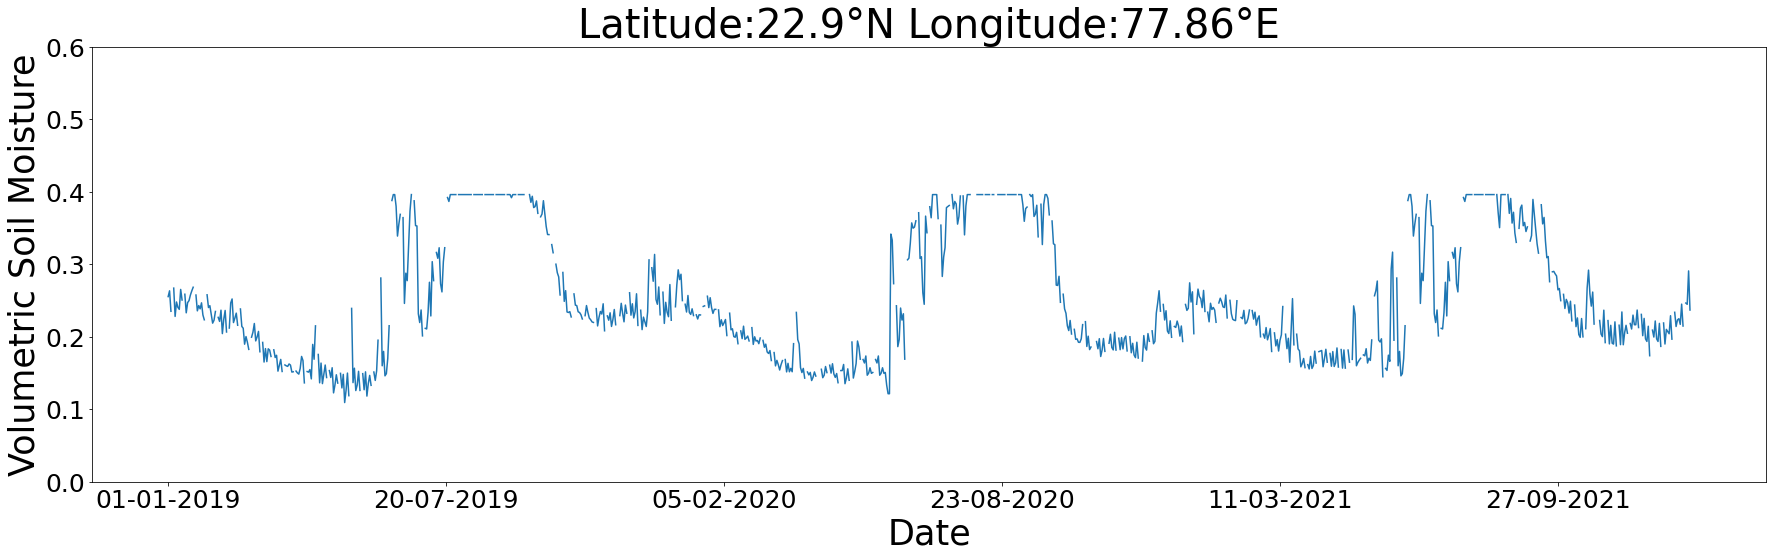

In [9]:
Data1  = pd.concat((Data.tail(365),Data.head(366+365)),axis=0)
Data1.index = Data1['Date']
Data1['SMAP_Soil_Moisture'].plot(figsize = (30,8),title='SMAP Soil Moisture')
plt.title(f'''Latitude:{lat}°N Longitude:{lon}°E''',size=40)  
plt.xlabel('Date',size=35)
plt.ylabel('Volumetric Soil Moisture',size=35)
plt.ylim(0,0.6)
plt.tick_params(axis='both',labelsize=25)

## Filled Missing Values using Linear Interpolation

In [10]:
Data = Data.interpolate()

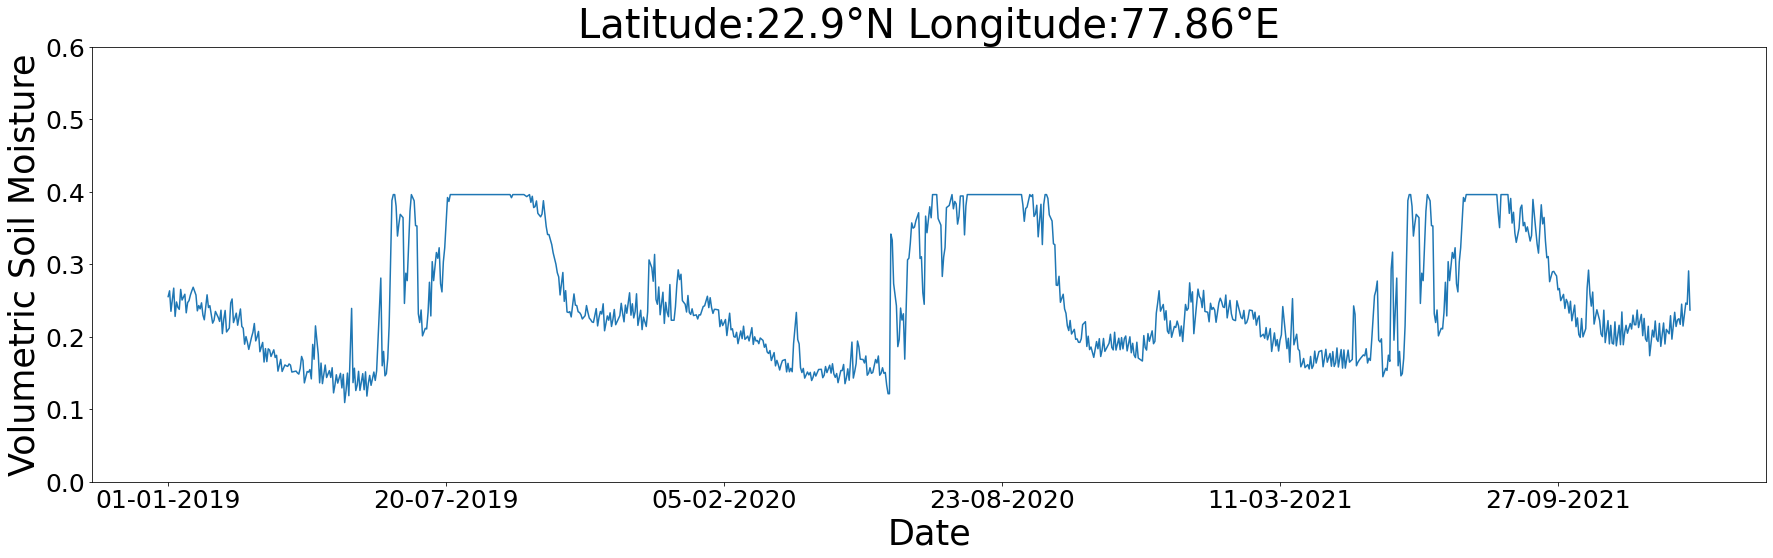

In [11]:
Data1  = pd.concat((Data.tail(365),Data.head(366+365)),axis=0)
Data1.index = Data1['Date']
Data1['SMAP_Soil_Moisture'].plot(figsize = (30,8),title='SMAP Soil Moisture')
plt.title(f'''Latitude:{lat}°N Longitude:{lon}°E''',size=40)  
plt.xlabel('Date',size=35)
plt.ylabel('Volumetric Soil Moisture',size=35)
plt.ylim(0,0.6)
plt.tick_params(axis='both',labelsize=25)

In [12]:
def DD_Time(Data):
    Year = []
    for i in range(len(Data)):
        DD = float(np.array(Data['Date'])[i][0:2])/30
        MM = float(np.array(Data['Date'])[i][3:5])
        Year.append(DD+MM)
    Data['Date'] = Year
    return Data
Data = DD_Time(Data) ## Date time column is string make them float

In [13]:
Data.corr()

,sp_inc_angle,sp_rx_gain,gps_tx_power_db_w,gps_ant_gain_db_i,ddm_snr,ddm_noise_floor,rx_to_sp_range,tx_to_sp_range,quality_flags,peak of power_analog,SR_eff,Date,SMAP_Soil_Moisture
sp_inc_angle,1.000000,0.155852,-0.155852,0.631393,0.066685,-0.024800,0.939559,0.880313,-0.011921,0.042225,-0.025757,-0.012234,-0.076271
sp_rx_gain,0.155852,1.000000,-0.015185,0.073477,0.485106,0.273021,0.129549,0.139711,-0.001923,0.477529,-0.017438,-0.126149,-0.175662
gps_tx_power_db_w,-0.155852,-0.015185,1.000000,-0.000131,0.135199,-0.033418,-0.118047,-0.261765,-0.004518,0.101848,0.000997,-0.026905,0.021073
gps_ant_gain_db_i,0.631393,0.073477,-0.000131,1.000000,0.090141,-0.036105,0.741085,0.590682,-0.030314,0.083485,0.021320,0.040307,-0.013361
ddm_snr,0.066685,0.485106,0.135199,0.090141,1.000000,-0.077843,0.072820,0.028705,-0.007179,0.863508,0.668610,0.108854,0.214282
ddm_noise_floor,-0.024800,0.273021,-0.033418,-0.036105,-0.077843,1.000000,-0.033386,0.001685,0.130190,-0.048245,-0.181619,-0.313984,-0.163445
rx_to_sp_range,0.939559,0.129549,-0.118047,0.741085,0.072820,-0.033386,1.000000,0.861090,-0.020655,0.048877,-0.022190,0.021137,-0.048087
tx_to_sp_range,0.880313,0.139711,-0.261765,0.590682,0.028705,0.001685,0.861090,1.000000,-0.034968,-0.019770,-0.074939,-0.017854,-0.052707
quality_flags,-0.011921,-0.001923,-0.004518,-0.030314,-0.007179,0.130190,-0.020655,-0.034968,1.000000,-0.000457,0.002785,0.022734,-0.029640
peak of power_analog,0.042225,0.477529,0.101848,0.083485,0.863508,-0.048245,0.048877,-0.019770,-0.000457,1.000000,0.803022,0.147690,0.250386


## Test and Train split

In [14]:
Data_Test  = Data.head(366)      # Test Data
Data_Train = Data.tail(365+365)  # Train Data

In [15]:
Data_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 366 to 1095
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sp_inc_angle          730 non-null    float64
 1   sp_rx_gain            730 non-null    float64
 2   gps_tx_power_db_w     730 non-null    float64
 3   gps_ant_gain_db_i     730 non-null    float64
 4   ddm_snr               730 non-null    float64
 5   ddm_noise_floor       730 non-null    float64
 6   rx_to_sp_range        730 non-null    float64
 7   tx_to_sp_range        730 non-null    float64
 8   quality_flags         730 non-null    float64
 9   peak of power_analog  730 non-null    float64
 10  SR_eff                730 non-null    float64
 11  Date                  730 non-null    float64
 12  SMAP_Soil_Moisture    730 non-null    float64
dtypes: float64(13)
memory usage: 74.3 KB


### Features:
* sp_inc_angle: Inclination angle of signal to the Nadir of specular point  
* sp_rx_gain: Gain of Receiver Antenna  
* gps_tx_power_db_w: GPS transmitting power
* gps_ant_gain_db_i: Gain of Transmitting Antenna 
* ddm_snr: DDM SNR  
* ddm_noise_floor: DDM Signal to Noise Ratio  
* rx_to_sp_range: Range between Receiver to Specular Point  
* tx_to_sp_range: Range between Transmitter to Specular Point
* quality_flags: Quality flags of the data
* peak of power_analog: Peak of the DDM
* SR_eff: Surface Reflectivity of the Specular point
* Date: Date

### Target variable:
* SMAP_Soil_Moisture: Taken from SMAP in 36 Km grid cell  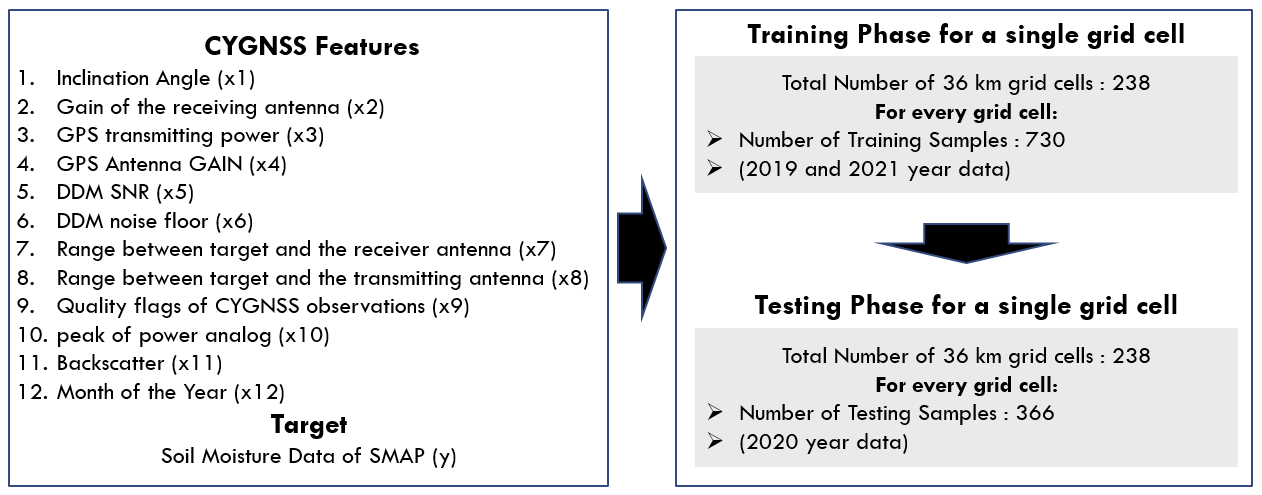

##  Features and Target variables

In [16]:
X_train = Data_Train.iloc[:,:-1]
y_train = Data_Train.iloc[:,-1]
X_test  = Data_Test.iloc[:,:-1]
y_test  = Data_Test.iloc[:,-1] 

<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">XGBoost Model Building </p> 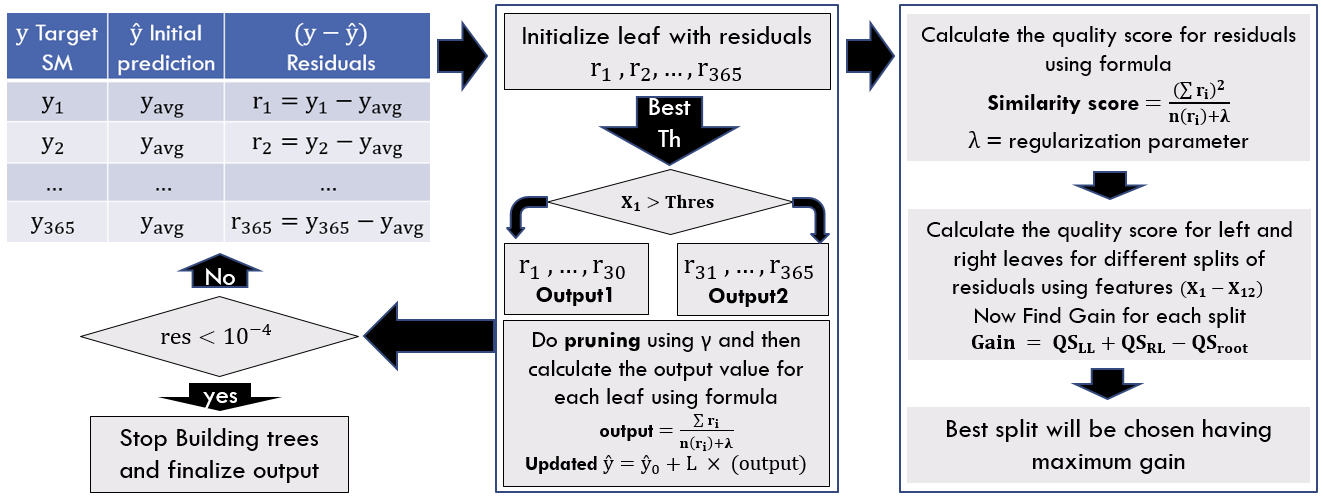

## Training on 2019 and 2021 Data

In [17]:
xgb_boost = XGBRegressor()
xgb_boost.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [18]:
from sklearn.metrics import mean_absolute_error
y_predt = xgb_boost.predict(X_test)
print("Mean Absolute Error : " + str(mean_absolute_error(y_predt, y_test)))
Accuracy2 = 100*np.round(r2_score(y_test, y_predt),2)
Accuracy2

Mean Absolute Error : 0.03204682860028814


74.0

## Model Tuning
+ n_estimators and early_stopping_rounds
  + n_estimators specifies how many times to go through the modeling cycle described above.

+ In the underfitting vs overfitting graph, n_estimators moves you further to the right. Too low a value causes underfitting, which is inaccurate predictions on both training data and new data. Too large a value causes overfitting, which is accurate predictions on training data, but inaccurate predictions on new data (which is what we care about). 

+ The argument early_stopping_rounds offers a way to automatically find the ideal value. Early stopping causes the model to stop iterating when the validation score stops improving, even if we aren't at the hard stop for n_estimators. 

+ It's smart to set a high value for n_estimators and then use early_stopping_rounds to find the optimal time to stop iterating.

+ Since random chance sometimes causes a single round where validation scores don't improve, you need to specify a number for how many rounds of straight deterioration to allow before stopping. early_stopping_rounds = 5 is a reasonable value. Thus we stop after 5 straight rounds of deteriorating validation scores.

In [19]:
xgb_boost = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_boost.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_set=[(X_test,y_test)])

[0]	validation_0-rmse:0.25487
[1]	validation_0-rmse:0.24287
[2]	validation_0-rmse:0.23150
[3]	validation_0-rmse:0.22077
[4]	validation_0-rmse:0.21056
[5]	validation_0-rmse:0.20089
[6]	validation_0-rmse:0.19172
[7]	validation_0-rmse:0.18303
[8]	validation_0-rmse:0.17480
[9]	validation_0-rmse:0.16700
[10]	validation_0-rmse:0.15961
[11]	validation_0-rmse:0.15265
[12]	validation_0-rmse:0.14603
[13]	validation_0-rmse:0.13990
[14]	validation_0-rmse:0.13413
[15]	validation_0-rmse:0.12856
[16]	validation_0-rmse:0.12344
[17]	validation_0-rmse:0.11842
[18]	validation_0-rmse:0.11382
[19]	validation_0-rmse:0.10943
[20]	validation_0-rmse:0.10540
[21]	validation_0-rmse:0.10151
[22]	validation_0-rmse:0.09789
[23]	validation_0-rmse:0.09435
[24]	validation_0-rmse:0.09116
[25]	validation_0-rmse:0.08803
[26]	validation_0-rmse:0.08514
[27]	validation_0-rmse:0.08241
[28]	validation_0-rmse:0.07985
[29]	validation_0-rmse:0.07751
[30]	validation_0-rmse:0.07531
[31]	validation_0-rmse:0.07316
[32]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [20]:
y_predt = xgb_boost.predict(X_test)

In [21]:
print("Mean Absolute Error : " + str(mean_absolute_error(y_predt, y_test)))

Mean Absolute Error : 0.031987527036961415


In [22]:
Accuracy2 = 100*np.round(r2_score(y_test, y_predt),2)
Accuracy2

73.0

## Tuning Learning Rate

In [23]:
def Best_Learning_Rate(L,Acc):
    for i in range(len(L)):
        acc = Acc[i]
        max1 = np.max(Acc)
        if acc==max1:
            lbest = L[i]
    return lbest

In [24]:
%%time
L = np.linspace(0.1,1,100)
Acc2 = []
for i in range(len(L)):
    l = L[i]
    xgb_boost = XGBRegressor(n_estimators=1000,learning_rate=l)
    xgb_boost.fit(X_train, y_train)
    y_predt = xgb_boost.predict(X_test)
    Accuracy2 = 100*np.round(r2_score(y_test, y_predt),2)
    Acc2.append(Accuracy2)
    
## Best Learning Rate tunned
xgb_boost = XGBRegressor(n_estimators=1000,learning_rate = Best_Learning_Rate(L,Acc2))
xgb_boost.fit(X_train, y_train)
y_predt = xgb_boost.predict(X_test)
Accuracy_GB = 100*np.round(r2_score(y_test, y_predt),2)

Wall time: 1min 30s


In [25]:
print("Mean Absolute Error : " + str(mean_absolute_error(y_predt, y_test)))

Mean Absolute Error : 0.033565579365444805


In [26]:
xgb_boost

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.9636363636363636,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [27]:
Accuracy_GB

74.0

# Testing XGBoost Model for 2020 CYGNSS features 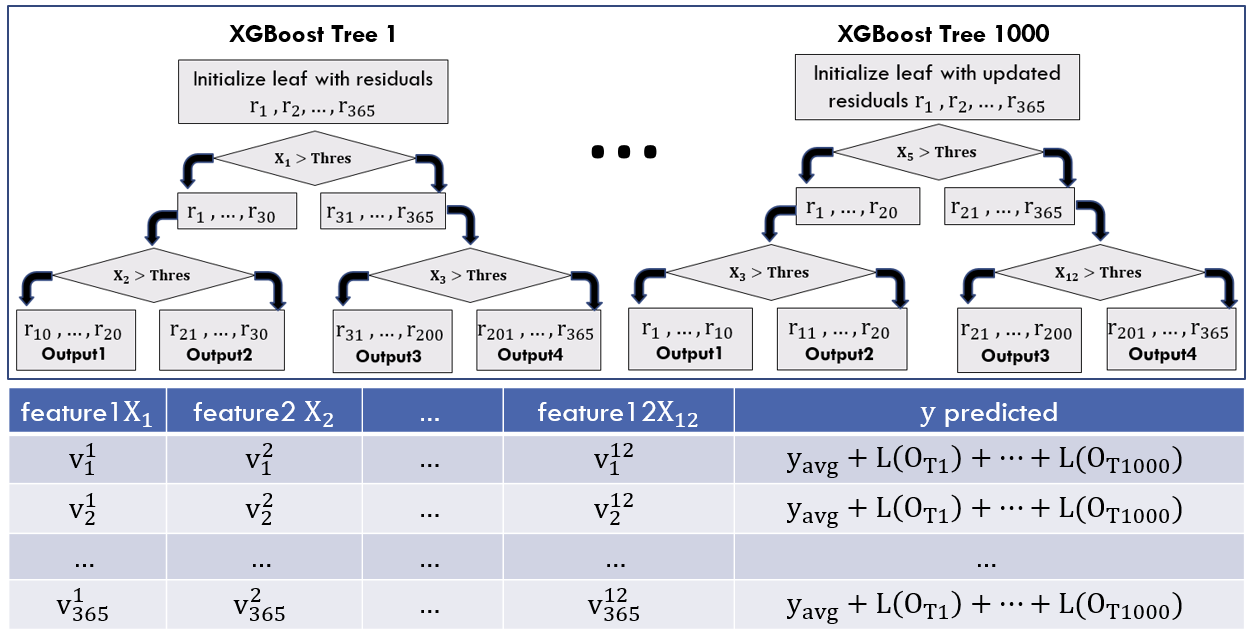

In [28]:
Data_Test['Predicted Soil Moisture'] = y_predt

## Droping Irrelevant Columns

In [29]:
Data_Test = Data_Test.drop(['sp_inc_angle', 'sp_rx_gain', 'gps_tx_power_db_w',
                                'gps_ant_gain_db_i','ddm_snr', 'ddm_noise_floor', 'rx_to_sp_range', 'tx_to_sp_range',
                                'quality_flags', 'peak of power_analog', 'SR_eff'],axis=1)

<AxesSubplot: >

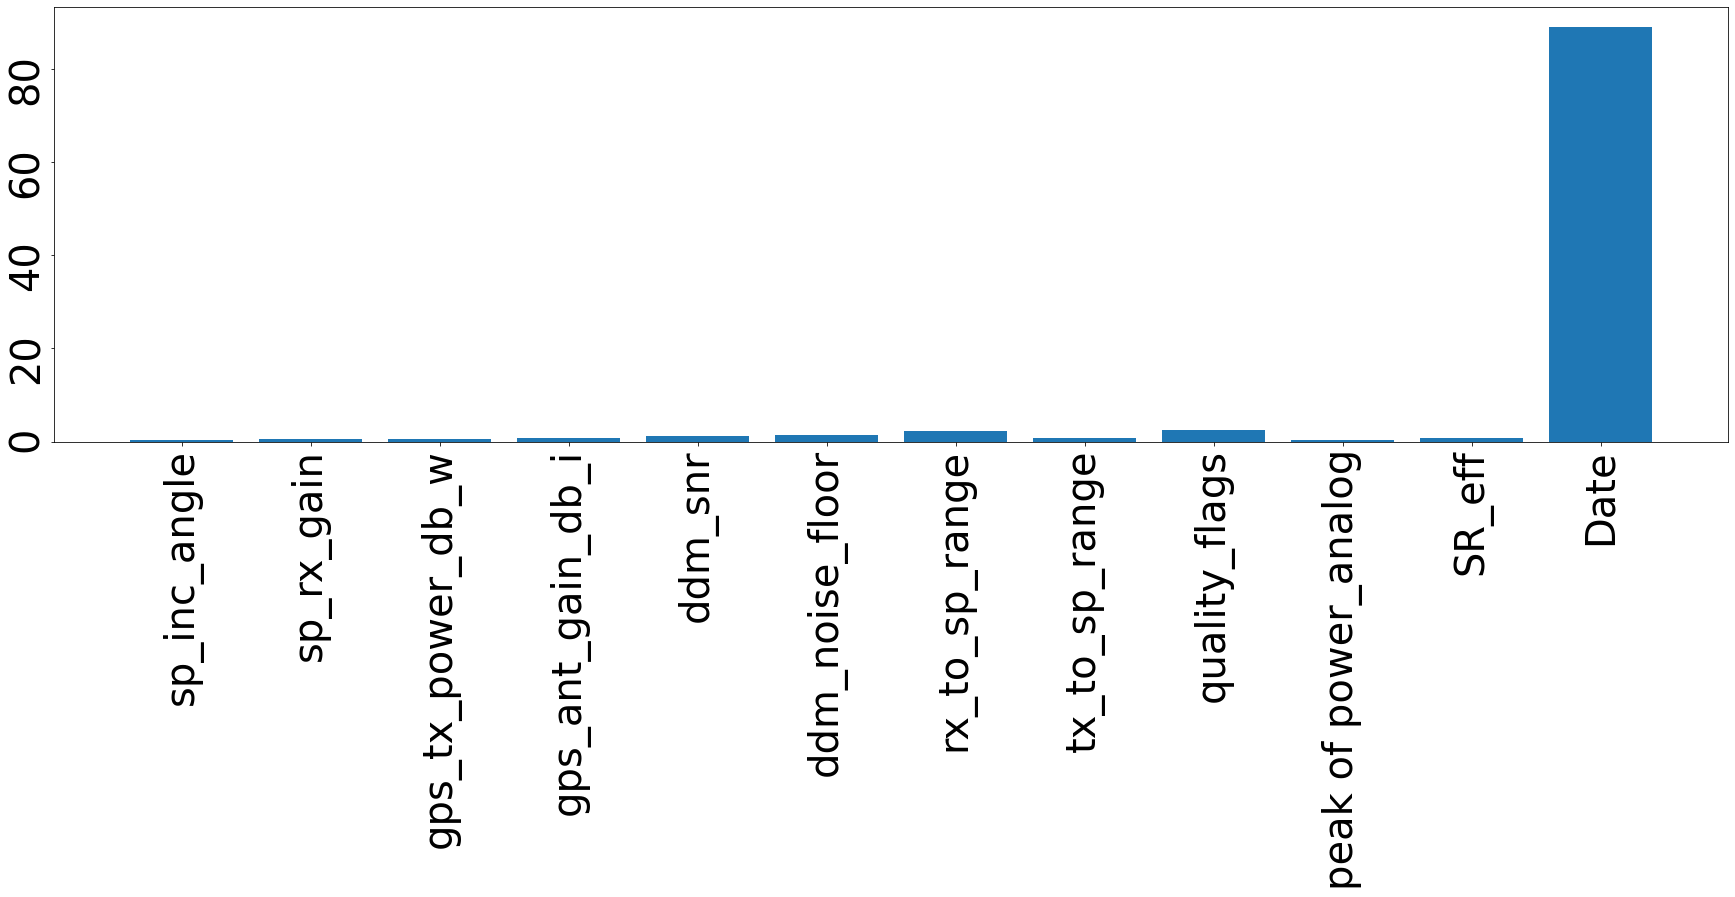

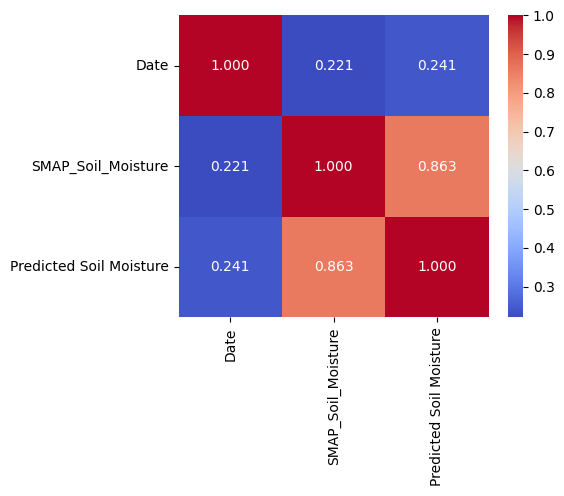

In [30]:
plt.figure(figsize=(30,8))
plt.bar(np.array(Data.iloc[:,:-1].keys()), 100*(xgb_boost.feature_importances_))
plt.tick_params(axis='both', labelsize=40, rotation =90)
    
plt.figure(figsize=(5,4),dpi=100)
sns.heatmap(Data_Test.corr(),cmap='coolwarm',fmt=".3f",annot=True)

In [31]:
Data_Test['Date'] = Data_Test.index+1

In [32]:
Data_Test

,Date,SMAP_Soil_Moisture,Predicted Soil Moisture
0,1,0.241491,0.291738
1,2,0.271814,0.261215
2,3,0.292451,0.237290
3,4,0.278970,0.241329
4,5,0.286393,0.238035
...,...,...,...
361,362,0.221781,0.254411
362,363,0.214862,0.229893
363,364,0.200981,0.236921
364,365,0.214971,0.212026


In [33]:
def Plotting_Variations(Data_Test,Accuracy_GB):
    CR = np.array(Data_Test.corr())[1][2]*100
    RMSE = round(np.sum((Data_Test['Predicted Soil Moisture'] - Data_Test['SMAP_Soil_Moisture'])**2)/len(Data_Test['SMAP_Soil_Moisture']),3)
    plt.figure(figsize=(30,8))
    plt.scatter(Data_Test['Date'],Data_Test['Predicted Soil Moisture'],label='Predicted Soil Moisture')
    plt.scatter(Data_Test['Date'],Data_Test['SMAP_Soil_Moisture'],label='SMAP Soil Moisture')
    plt.title(f'''Latitude:{lat}°N Longitude:{lon}°E RMSE:{round(RMSE,4)} 
    Correlation:{np.round(CR,2)}% NSE or CD:{Accuracy_GB}%''',size=40)  
    plt.xlabel('Day number of the year 2020',size=35)
    plt.ylabel('Volumetric Soil Moisture',size=35)
    plt.ylim(0,1)
    plt.xticks(np.arange(1, 370, 20),size=25)
    plt.yticks(np.arange(0, 1, 0.1),size=25)
    plt.legend(fontsize=35)
    plt.figure(figsize=(8,8))
    sns.lmplot(x=f'SMAP_Soil_Moisture',y=f'Predicted Soil Moisture',data=Data_Test,line_kws={'color': 'black'})
    plt.xlabel(f'SMAP Soil Moisture',size=20)
    plt.ylabel(f'Predicted Soil Moisture',size=20)
    plt.plot([0,1],[0,1],c='gray')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xticks(np.arange(0, 1, 0.2))
    plt.yticks(np.arange(0, 1, 0.2))
    plt.tick_params(axis='both', labelsize=20)

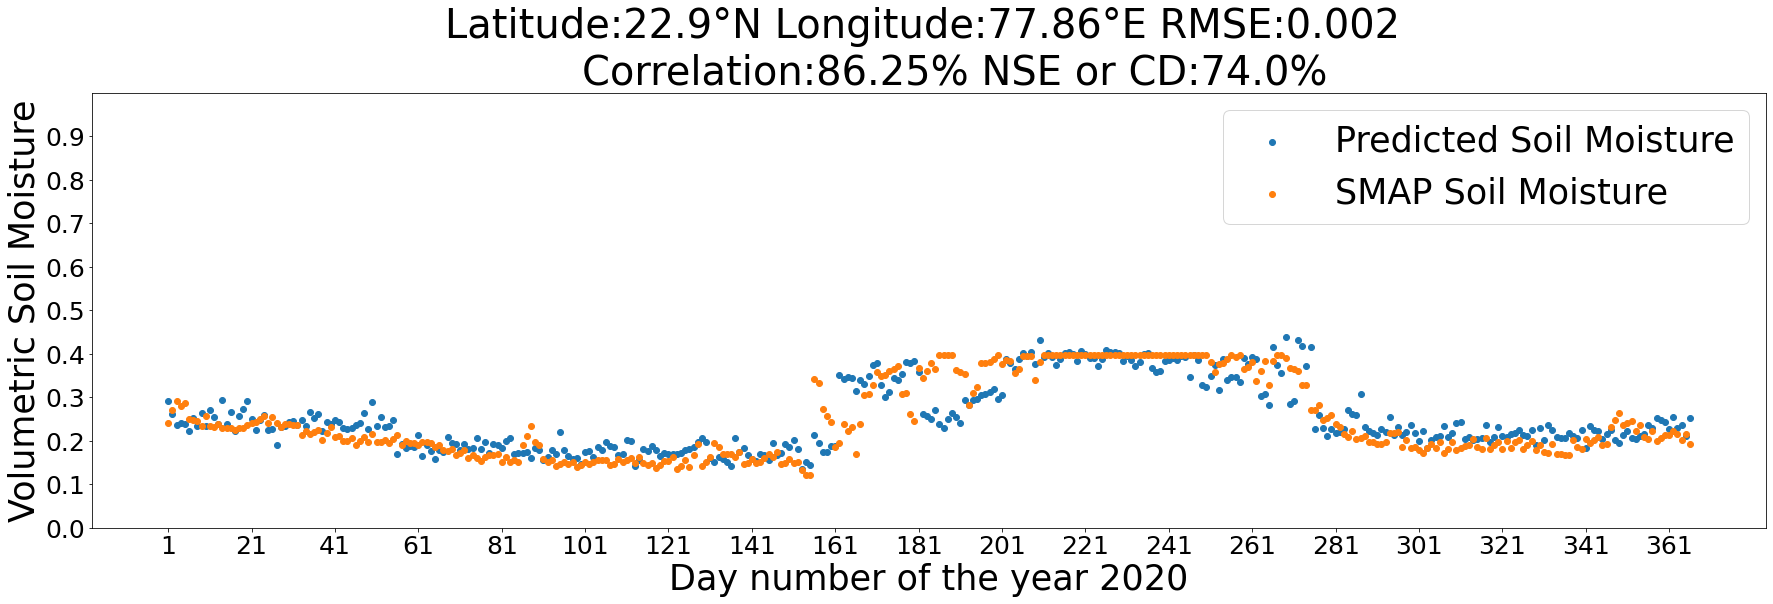

<Figure size 576x576 with 0 Axes>

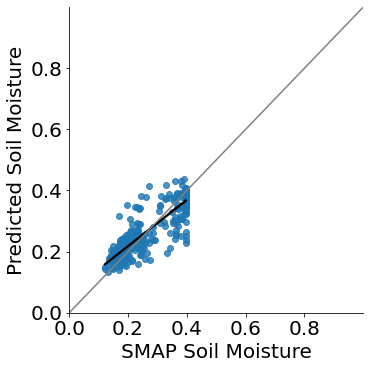

In [34]:
Plotting_Variations(Data_Test,Accuracy_GB)

<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Light GBM Model Building </p>

In [35]:
from lightgbm import LGBMRegressor as lgbm

In [36]:
%%time
L = np.linspace(0.01,0.1,100)
Acc2 = []
for i in range(len(L)):
    l = L[i]
    lgbm1 = lgbm(n_estimators=1000,learning_rate=l)
    lgbm1.fit(X_train, y_train)
    y_predt = lgbm1.predict(X_test)
    Accuracy2 = 100*np.round(r2_score(y_test, y_predt),2)
    Acc2.append(Accuracy2)
    
## Best Learning Rate tunned
lgbm1 = lgbm(n_estimators=1000,learning_rate = Best_Learning_Rate(L,Acc2))
lgbm1.fit(X_train, y_train)
y_predt = lgbm1.predict(X_test)
Accuracy_GB = 100*np.round(r2_score(y_test, y_predt),2)

Wall time: 1min 12s


In [37]:
print("Mean Absolute Error : " + str(mean_absolute_error(y_predt, y_test)))
Accuracy_GB

Mean Absolute Error : 0.030925716657461258


76.0

In [38]:
FI = lgbm1.feature_importances_

<AxesSubplot: >

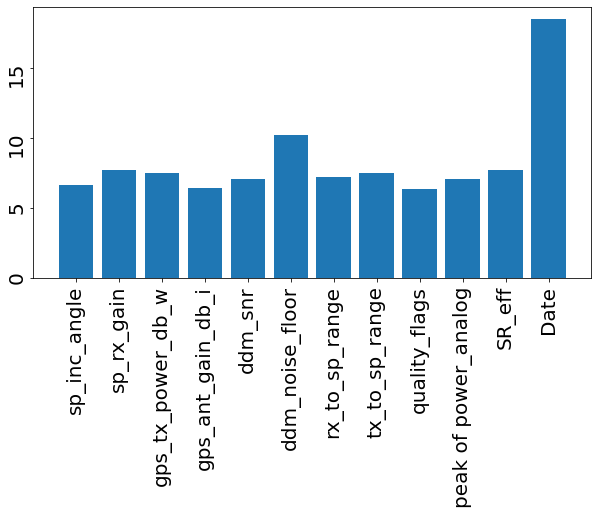

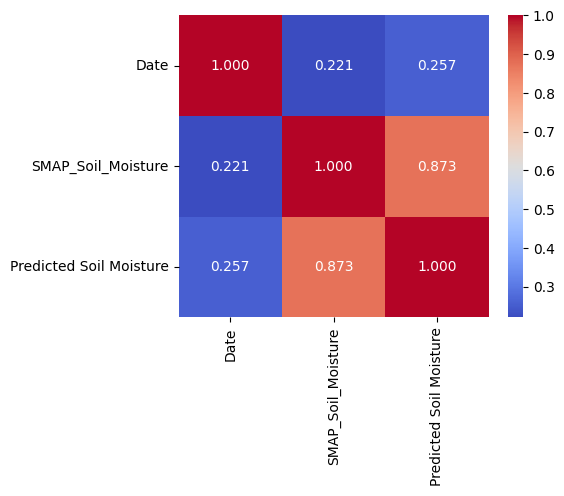

In [39]:
Data_Test['Predicted Soil Moisture'] = y_predt
plt.figure(figsize=(10,5))
plt.bar(np.array(Data.iloc[:,:-1].keys()), 100*(FI/np.sum(FI)))
plt.tick_params(axis='both', labelsize=20, rotation =90)
    
plt.figure(figsize=(5,4),dpi=100)
sns.heatmap(Data_Test.corr(),cmap='coolwarm',fmt=".3f",annot=True)

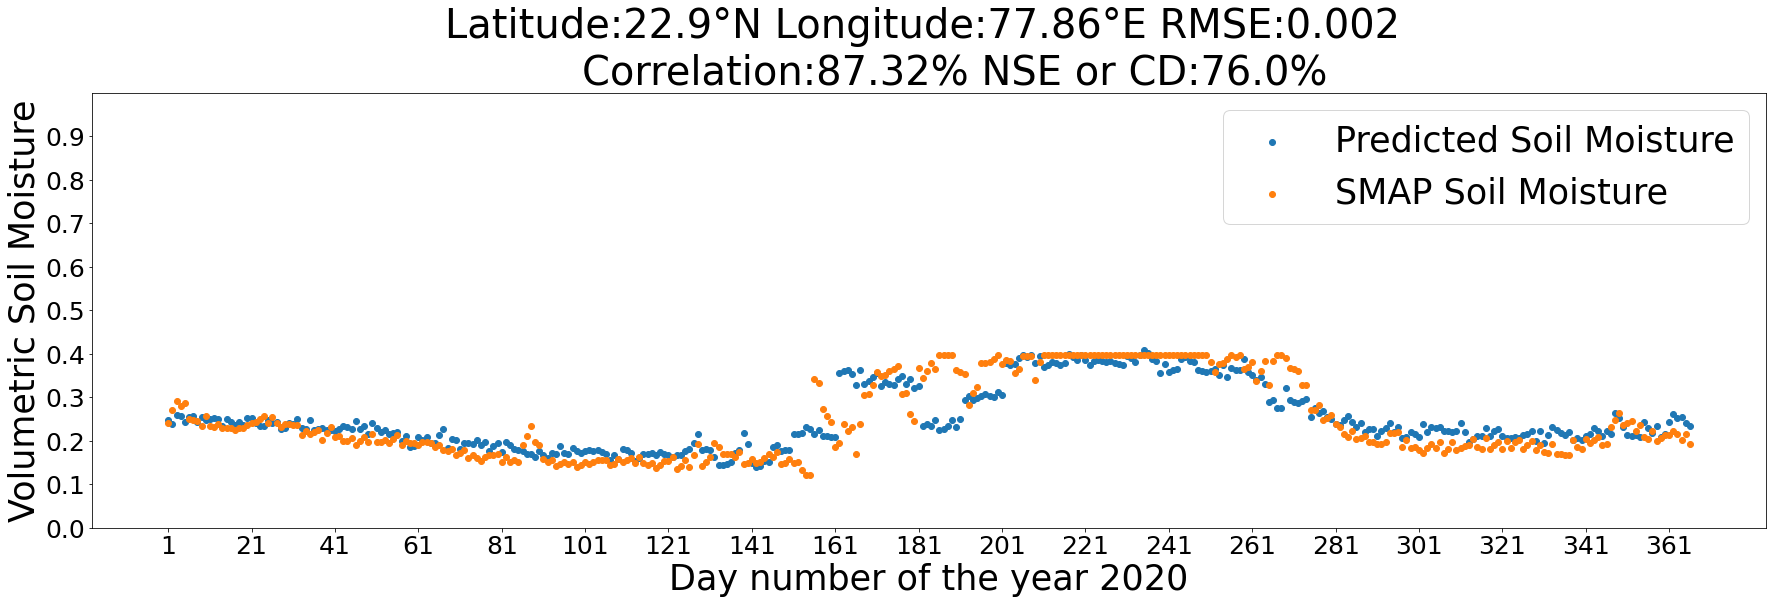

<Figure size 576x576 with 0 Axes>

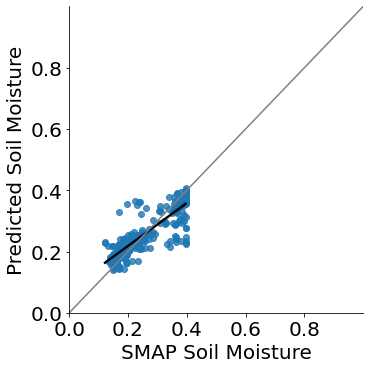

In [40]:
Plotting_Variations(Data_Test,Accuracy_GB)

<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">CatBoost Model Building </p>

In [41]:
from catboost import CatBoostRegressor

In [42]:
cat_boost = CatBoostRegressor()
cat_boost.fit(X_train, y_train)

Learning rate set to 0.038957
0:	learn: 0.0782103	total: 208ms	remaining: 3m 27s
1:	learn: 0.0764343	total: 210ms	remaining: 1m 44s
2:	learn: 0.0746504	total: 212ms	remaining: 1m 10s
3:	learn: 0.0726325	total: 214ms	remaining: 53.2s
4:	learn: 0.0706441	total: 215ms	remaining: 42.8s
5:	learn: 0.0687636	total: 217ms	remaining: 36s
6:	learn: 0.0671376	total: 219ms	remaining: 31s
7:	learn: 0.0654393	total: 221ms	remaining: 27.3s
8:	learn: 0.0639590	total: 222ms	remaining: 24.5s
9:	learn: 0.0625595	total: 224ms	remaining: 22.2s
10:	learn: 0.0612547	total: 226ms	remaining: 20.3s
11:	learn: 0.0600461	total: 227ms	remaining: 18.7s
12:	learn: 0.0589402	total: 229ms	remaining: 17.4s
13:	learn: 0.0575991	total: 231ms	remaining: 16.3s
14:	learn: 0.0564938	total: 233ms	remaining: 15.3s
15:	learn: 0.0552763	total: 235ms	remaining: 14.5s
16:	learn: 0.0541481	total: 237ms	remaining: 13.7s
17:	learn: 0.0530480	total: 239ms	remaining: 13s
18:	learn: 0.0520608	total: 241ms	remaining: 12.4s
19:	learn: 0.0

185:	learn: 0.0204654	total: 550ms	remaining: 2.41s
186:	learn: 0.0204364	total: 552ms	remaining: 2.4s
187:	learn: 0.0204024	total: 554ms	remaining: 2.39s
188:	learn: 0.0203637	total: 556ms	remaining: 2.39s
189:	learn: 0.0203367	total: 558ms	remaining: 2.38s
190:	learn: 0.0202981	total: 560ms	remaining: 2.37s
191:	learn: 0.0202037	total: 563ms	remaining: 2.37s
192:	learn: 0.0201844	total: 565ms	remaining: 2.36s
193:	learn: 0.0201055	total: 568ms	remaining: 2.36s
194:	learn: 0.0200826	total: 570ms	remaining: 2.35s
195:	learn: 0.0200505	total: 572ms	remaining: 2.35s
196:	learn: 0.0200165	total: 574ms	remaining: 2.34s
197:	learn: 0.0199957	total: 576ms	remaining: 2.33s
198:	learn: 0.0199666	total: 579ms	remaining: 2.33s
199:	learn: 0.0199060	total: 581ms	remaining: 2.32s
200:	learn: 0.0198761	total: 583ms	remaining: 2.32s
201:	learn: 0.0198382	total: 585ms	remaining: 2.31s
202:	learn: 0.0197701	total: 588ms	remaining: 2.31s
203:	learn: 0.0197452	total: 591ms	remaining: 2.3s
204:	learn: 0.

360:	learn: 0.0144486	total: 896ms	remaining: 1.58s
361:	learn: 0.0144177	total: 898ms	remaining: 1.58s
362:	learn: 0.0143987	total: 900ms	remaining: 1.58s
363:	learn: 0.0143838	total: 902ms	remaining: 1.57s
364:	learn: 0.0143770	total: 904ms	remaining: 1.57s
365:	learn: 0.0143385	total: 905ms	remaining: 1.57s
366:	learn: 0.0143256	total: 908ms	remaining: 1.56s
367:	learn: 0.0143063	total: 910ms	remaining: 1.56s
368:	learn: 0.0142892	total: 912ms	remaining: 1.56s
369:	learn: 0.0142792	total: 913ms	remaining: 1.55s
370:	learn: 0.0142682	total: 915ms	remaining: 1.55s
371:	learn: 0.0142471	total: 917ms	remaining: 1.55s
372:	learn: 0.0142385	total: 919ms	remaining: 1.54s
373:	learn: 0.0142117	total: 921ms	remaining: 1.54s
374:	learn: 0.0141765	total: 923ms	remaining: 1.54s
375:	learn: 0.0141473	total: 925ms	remaining: 1.53s
376:	learn: 0.0141227	total: 927ms	remaining: 1.53s
377:	learn: 0.0140928	total: 929ms	remaining: 1.53s
378:	learn: 0.0140653	total: 930ms	remaining: 1.52s
379:	learn: 

541:	learn: 0.0113201	total: 1.24s	remaining: 1.05s
542:	learn: 0.0113044	total: 1.24s	remaining: 1.04s
543:	learn: 0.0112974	total: 1.24s	remaining: 1.04s
544:	learn: 0.0112790	total: 1.25s	remaining: 1.04s
545:	learn: 0.0112703	total: 1.25s	remaining: 1.04s
546:	learn: 0.0112648	total: 1.25s	remaining: 1.03s
547:	learn: 0.0112487	total: 1.25s	remaining: 1.03s
548:	learn: 0.0112217	total: 1.25s	remaining: 1.03s
549:	learn: 0.0112206	total: 1.25s	remaining: 1.03s
550:	learn: 0.0112194	total: 1.26s	remaining: 1.02s
551:	learn: 0.0111981	total: 1.26s	remaining: 1.02s
552:	learn: 0.0111694	total: 1.26s	remaining: 1.02s
553:	learn: 0.0111585	total: 1.26s	remaining: 1.02s
554:	learn: 0.0111545	total: 1.26s	remaining: 1.01s
555:	learn: 0.0111496	total: 1.27s	remaining: 1.01s
556:	learn: 0.0111277	total: 1.27s	remaining: 1.01s
557:	learn: 0.0111105	total: 1.27s	remaining: 1.01s
558:	learn: 0.0110795	total: 1.27s	remaining: 1s
559:	learn: 0.0110647	total: 1.27s	remaining: 1s
560:	learn: 0.0110

725:	learn: 0.0091050	total: 1.59s	remaining: 599ms
726:	learn: 0.0091021	total: 1.59s	remaining: 597ms
727:	learn: 0.0090869	total: 1.59s	remaining: 595ms
728:	learn: 0.0090807	total: 1.59s	remaining: 593ms
729:	learn: 0.0090675	total: 1.59s	remaining: 590ms
730:	learn: 0.0090489	total: 1.6s	remaining: 588ms
731:	learn: 0.0090372	total: 1.6s	remaining: 587ms
732:	learn: 0.0090196	total: 1.6s	remaining: 585ms
733:	learn: 0.0090087	total: 1.61s	remaining: 583ms
734:	learn: 0.0089904	total: 1.61s	remaining: 580ms
735:	learn: 0.0089812	total: 1.61s	remaining: 578ms
736:	learn: 0.0089674	total: 1.61s	remaining: 576ms
737:	learn: 0.0089621	total: 1.62s	remaining: 574ms
738:	learn: 0.0089388	total: 1.62s	remaining: 572ms
739:	learn: 0.0089326	total: 1.62s	remaining: 569ms
740:	learn: 0.0089254	total: 1.62s	remaining: 567ms
741:	learn: 0.0089148	total: 1.62s	remaining: 565ms
742:	learn: 0.0089094	total: 1.63s	remaining: 562ms
743:	learn: 0.0088971	total: 1.63s	remaining: 560ms
744:	learn: 0.0

883:	learn: 0.0076666	total: 1.93s	remaining: 253ms
884:	learn: 0.0076555	total: 1.93s	remaining: 251ms
885:	learn: 0.0076483	total: 1.93s	remaining: 249ms
886:	learn: 0.0076449	total: 1.94s	remaining: 247ms
887:	learn: 0.0076421	total: 1.94s	remaining: 244ms
888:	learn: 0.0076291	total: 1.94s	remaining: 242ms
889:	learn: 0.0076270	total: 1.94s	remaining: 240ms
890:	learn: 0.0076250	total: 1.94s	remaining: 238ms
891:	learn: 0.0076179	total: 1.95s	remaining: 236ms
892:	learn: 0.0076100	total: 1.95s	remaining: 233ms
893:	learn: 0.0076092	total: 1.95s	remaining: 231ms
894:	learn: 0.0076007	total: 1.95s	remaining: 229ms
895:	learn: 0.0075885	total: 1.95s	remaining: 227ms
896:	learn: 0.0075844	total: 1.96s	remaining: 225ms
897:	learn: 0.0075825	total: 1.96s	remaining: 222ms
898:	learn: 0.0075816	total: 1.96s	remaining: 220ms
899:	learn: 0.0075707	total: 1.96s	remaining: 218ms
900:	learn: 0.0075620	total: 1.97s	remaining: 216ms
901:	learn: 0.0075546	total: 1.97s	remaining: 214ms
902:	learn: 

In [43]:
y_predt = cat_boost.predict(X_test)
print("Mean Absolute Error : " + str(mean_absolute_error(y_predt, y_test)))
Accuracy2 = 100*np.round(r2_score(y_test, y_predt),2)
Accuracy2

Mean Absolute Error : 0.031055827053607807


78.0

## Model Tuning
+ n_estimators specifies how many times to go through the modeling cycle described above.
+ Too low a value causes underfitting, Too large a value causes overfitting
+ Early stopping causes the model to stop iterating when the validation score stops improving. 

In [44]:
cat_boost = CatBoostRegressor(n_estimators=5000, learning_rate=0.01)
cat_boost.fit(X_train, y_train, verbose=True, eval_set=[(X_test,y_test)])

0:	learn: 0.0798817	test: 0.0885616	best: 0.0885616 (0)	total: 5.12ms	remaining: 25.6s
1:	learn: 0.0794086	test: 0.0881112	best: 0.0881112 (1)	total: 9.33ms	remaining: 23.3s
2:	learn: 0.0789284	test: 0.0876223	best: 0.0876223 (2)	total: 13.7ms	remaining: 22.7s
3:	learn: 0.0783864	test: 0.0870771	best: 0.0870771 (3)	total: 18.4ms	remaining: 23s
4:	learn: 0.0778171	test: 0.0865230	best: 0.0865230 (4)	total: 22ms	remaining: 21.9s
5:	learn: 0.0772606	test: 0.0859726	best: 0.0859726 (5)	total: 25.2ms	remaining: 21s
6:	learn: 0.0767275	test: 0.0854518	best: 0.0854518 (6)	total: 28.3ms	remaining: 20.2s
7:	learn: 0.0762034	test: 0.0849166	best: 0.0849166 (7)	total: 31.2ms	remaining: 19.5s
8:	learn: 0.0757218	test: 0.0844246	best: 0.0844246 (8)	total: 33.6ms	remaining: 18.6s
9:	learn: 0.0752514	test: 0.0839692	best: 0.0839692 (9)	total: 36ms	remaining: 17.9s
10:	learn: 0.0747825	test: 0.0835288	best: 0.0835288 (10)	total: 38.3ms	remaining: 17.4s
11:	learn: 0.0743485	test: 0.0831355	best: 0.0831

131:	learn: 0.0413533	test: 0.0496496	best: 0.0496496 (131)	total: 271ms	remaining: 9.99s
132:	learn: 0.0412023	test: 0.0494975	best: 0.0494975 (132)	total: 273ms	remaining: 9.99s
133:	learn: 0.0410910	test: 0.0493770	best: 0.0493770 (133)	total: 275ms	remaining: 9.99s
134:	learn: 0.0409542	test: 0.0492376	best: 0.0492376 (134)	total: 277ms	remaining: 9.98s
135:	learn: 0.0408304	test: 0.0490934	best: 0.0490934 (135)	total: 279ms	remaining: 9.98s
136:	learn: 0.0407062	test: 0.0489399	best: 0.0489399 (136)	total: 281ms	remaining: 9.98s
137:	learn: 0.0405518	test: 0.0487626	best: 0.0487626 (137)	total: 284ms	remaining: 9.99s
138:	learn: 0.0404152	test: 0.0486350	best: 0.0486350 (138)	total: 286ms	remaining: 10s
139:	learn: 0.0402508	test: 0.0484769	best: 0.0484769 (139)	total: 289ms	remaining: 10s
140:	learn: 0.0401271	test: 0.0483508	best: 0.0483508 (140)	total: 291ms	remaining: 10s
141:	learn: 0.0399785	test: 0.0481760	best: 0.0481760 (141)	total: 293ms	remaining: 10s
142:	learn: 0.0398

253:	learn: 0.0307722	test: 0.0397397	best: 0.0397397 (253)	total: 511ms	remaining: 9.54s
254:	learn: 0.0307146	test: 0.0396838	best: 0.0396838 (254)	total: 512ms	remaining: 9.54s
255:	learn: 0.0306796	test: 0.0396452	best: 0.0396452 (255)	total: 514ms	remaining: 9.53s
256:	learn: 0.0306344	test: 0.0395825	best: 0.0395825 (256)	total: 516ms	remaining: 9.52s
257:	learn: 0.0305928	test: 0.0395472	best: 0.0395472 (257)	total: 518ms	remaining: 9.52s
258:	learn: 0.0305451	test: 0.0394842	best: 0.0394842 (258)	total: 520ms	remaining: 9.51s
259:	learn: 0.0305133	test: 0.0394696	best: 0.0394696 (259)	total: 521ms	remaining: 9.51s
260:	learn: 0.0304721	test: 0.0394583	best: 0.0394583 (260)	total: 523ms	remaining: 9.5s
261:	learn: 0.0304290	test: 0.0394203	best: 0.0394203 (261)	total: 525ms	remaining: 9.49s
262:	learn: 0.0303748	test: 0.0393722	best: 0.0393722 (262)	total: 527ms	remaining: 9.49s
263:	learn: 0.0303248	test: 0.0393631	best: 0.0393631 (263)	total: 529ms	remaining: 9.48s
264:	learn:

395:	learn: 0.0261804	test: 0.0376267	best: 0.0376266 (393)	total: 785ms	remaining: 9.12s
396:	learn: 0.0261300	test: 0.0376190	best: 0.0376190 (396)	total: 787ms	remaining: 9.12s
397:	learn: 0.0261007	test: 0.0376086	best: 0.0376086 (397)	total: 789ms	remaining: 9.12s
398:	learn: 0.0260850	test: 0.0376020	best: 0.0376020 (398)	total: 791ms	remaining: 9.12s
399:	learn: 0.0260715	test: 0.0376008	best: 0.0376008 (399)	total: 793ms	remaining: 9.12s
400:	learn: 0.0260496	test: 0.0375904	best: 0.0375904 (400)	total: 795ms	remaining: 9.12s
401:	learn: 0.0260127	test: 0.0375929	best: 0.0375904 (400)	total: 797ms	remaining: 9.11s
402:	learn: 0.0260022	test: 0.0375916	best: 0.0375904 (400)	total: 799ms	remaining: 9.11s
403:	learn: 0.0259707	test: 0.0376044	best: 0.0375904 (400)	total: 801ms	remaining: 9.11s
404:	learn: 0.0259417	test: 0.0375764	best: 0.0375764 (404)	total: 803ms	remaining: 9.11s
405:	learn: 0.0259154	test: 0.0375954	best: 0.0375764 (404)	total: 805ms	remaining: 9.1s
406:	learn:

519:	learn: 0.0239049	test: 0.0374750	best: 0.0374625 (482)	total: 1.02s	remaining: 8.84s
520:	learn: 0.0238663	test: 0.0374716	best: 0.0374625 (482)	total: 1.03s	remaining: 8.84s
521:	learn: 0.0238536	test: 0.0374593	best: 0.0374593 (521)	total: 1.03s	remaining: 8.83s
522:	learn: 0.0238307	test: 0.0374608	best: 0.0374593 (521)	total: 1.03s	remaining: 8.83s
523:	learn: 0.0238176	test: 0.0374572	best: 0.0374572 (523)	total: 1.03s	remaining: 8.83s
524:	learn: 0.0238044	test: 0.0374610	best: 0.0374572 (523)	total: 1.04s	remaining: 8.83s
525:	learn: 0.0237911	test: 0.0374626	best: 0.0374572 (523)	total: 1.04s	remaining: 8.84s
526:	learn: 0.0237793	test: 0.0374592	best: 0.0374572 (523)	total: 1.04s	remaining: 8.83s
527:	learn: 0.0237582	test: 0.0374586	best: 0.0374572 (523)	total: 1.04s	remaining: 8.83s
528:	learn: 0.0237486	test: 0.0374504	best: 0.0374504 (528)	total: 1.04s	remaining: 8.83s
529:	learn: 0.0237348	test: 0.0374414	best: 0.0374414 (529)	total: 1.05s	remaining: 8.83s
530:	learn

657:	learn: 0.0218962	test: 0.0374418	best: 0.0374024 (573)	total: 1.3s	remaining: 8.57s
658:	learn: 0.0218822	test: 0.0374267	best: 0.0374024 (573)	total: 1.3s	remaining: 8.57s
659:	learn: 0.0218723	test: 0.0374190	best: 0.0374024 (573)	total: 1.3s	remaining: 8.57s
660:	learn: 0.0218628	test: 0.0374197	best: 0.0374024 (573)	total: 1.3s	remaining: 8.56s
661:	learn: 0.0218344	test: 0.0374352	best: 0.0374024 (573)	total: 1.31s	remaining: 8.56s
662:	learn: 0.0218232	test: 0.0374371	best: 0.0374024 (573)	total: 1.31s	remaining: 8.56s
663:	learn: 0.0218121	test: 0.0374357	best: 0.0374024 (573)	total: 1.31s	remaining: 8.56s
664:	learn: 0.0218047	test: 0.0374353	best: 0.0374024 (573)	total: 1.31s	remaining: 8.56s
665:	learn: 0.0217914	test: 0.0374321	best: 0.0374024 (573)	total: 1.31s	remaining: 8.56s
666:	learn: 0.0217661	test: 0.0374538	best: 0.0374024 (573)	total: 1.32s	remaining: 8.55s
667:	learn: 0.0217565	test: 0.0374514	best: 0.0374024 (573)	total: 1.32s	remaining: 8.55s
668:	learn: 0.

773:	learn: 0.0202506	test: 0.0377168	best: 0.0374024 (573)	total: 1.54s	remaining: 8.41s
774:	learn: 0.0202290	test: 0.0377209	best: 0.0374024 (573)	total: 1.54s	remaining: 8.41s
775:	learn: 0.0202068	test: 0.0377418	best: 0.0374024 (573)	total: 1.54s	remaining: 8.41s
776:	learn: 0.0201939	test: 0.0377440	best: 0.0374024 (573)	total: 1.55s	remaining: 8.41s
777:	learn: 0.0201808	test: 0.0377415	best: 0.0374024 (573)	total: 1.55s	remaining: 8.41s
778:	learn: 0.0201677	test: 0.0377446	best: 0.0374024 (573)	total: 1.55s	remaining: 8.41s
779:	learn: 0.0201547	test: 0.0377431	best: 0.0374024 (573)	total: 1.55s	remaining: 8.41s
780:	learn: 0.0201406	test: 0.0377356	best: 0.0374024 (573)	total: 1.56s	remaining: 8.41s
781:	learn: 0.0201315	test: 0.0377341	best: 0.0374024 (573)	total: 1.56s	remaining: 8.41s
782:	learn: 0.0201178	test: 0.0377338	best: 0.0374024 (573)	total: 1.56s	remaining: 8.41s
783:	learn: 0.0200990	test: 0.0377340	best: 0.0374024 (573)	total: 1.56s	remaining: 8.41s
784:	learn

908:	learn: 0.0184865	test: 0.0381693	best: 0.0374024 (573)	total: 1.81s	remaining: 8.15s
909:	learn: 0.0184808	test: 0.0381709	best: 0.0374024 (573)	total: 1.81s	remaining: 8.15s
910:	learn: 0.0184595	test: 0.0381847	best: 0.0374024 (573)	total: 1.81s	remaining: 8.15s
911:	learn: 0.0184483	test: 0.0381778	best: 0.0374024 (573)	total: 1.82s	remaining: 8.14s
912:	learn: 0.0184411	test: 0.0381799	best: 0.0374024 (573)	total: 1.82s	remaining: 8.14s
913:	learn: 0.0184295	test: 0.0381896	best: 0.0374024 (573)	total: 1.82s	remaining: 8.14s
914:	learn: 0.0184200	test: 0.0381894	best: 0.0374024 (573)	total: 1.82s	remaining: 8.14s
915:	learn: 0.0184107	test: 0.0381861	best: 0.0374024 (573)	total: 1.82s	remaining: 8.13s
916:	learn: 0.0183939	test: 0.0381929	best: 0.0374024 (573)	total: 1.83s	remaining: 8.13s
917:	learn: 0.0183855	test: 0.0381954	best: 0.0374024 (573)	total: 1.83s	remaining: 8.13s
918:	learn: 0.0183710	test: 0.0381976	best: 0.0374024 (573)	total: 1.83s	remaining: 8.13s
919:	learn

1001:	learn: 0.0175193	test: 0.0384218	best: 0.0374024 (573)	total: 2.02s	remaining: 8.08s
1002:	learn: 0.0175091	test: 0.0384287	best: 0.0374024 (573)	total: 2.03s	remaining: 8.08s
1003:	learn: 0.0175064	test: 0.0384297	best: 0.0374024 (573)	total: 2.03s	remaining: 8.08s
1004:	learn: 0.0175004	test: 0.0384299	best: 0.0374024 (573)	total: 2.03s	remaining: 8.08s
1005:	learn: 0.0174947	test: 0.0384304	best: 0.0374024 (573)	total: 2.03s	remaining: 8.07s
1006:	learn: 0.0174888	test: 0.0384303	best: 0.0374024 (573)	total: 2.04s	remaining: 8.07s
1007:	learn: 0.0174792	test: 0.0384299	best: 0.0374024 (573)	total: 2.04s	remaining: 8.07s
1008:	learn: 0.0174728	test: 0.0384324	best: 0.0374024 (573)	total: 2.04s	remaining: 8.06s
1009:	learn: 0.0174672	test: 0.0384330	best: 0.0374024 (573)	total: 2.04s	remaining: 8.06s
1010:	learn: 0.0174560	test: 0.0384431	best: 0.0374024 (573)	total: 2.04s	remaining: 8.06s
1011:	learn: 0.0174501	test: 0.0384441	best: 0.0374024 (573)	total: 2.04s	remaining: 8.05s

1093:	learn: 0.0167314	test: 0.0386498	best: 0.0374024 (573)	total: 2.2s	remaining: 7.85s
1094:	learn: 0.0167246	test: 0.0386495	best: 0.0374024 (573)	total: 2.2s	remaining: 7.84s
1095:	learn: 0.0167174	test: 0.0386508	best: 0.0374024 (573)	total: 2.2s	remaining: 7.84s
1096:	learn: 0.0167106	test: 0.0386479	best: 0.0374024 (573)	total: 2.2s	remaining: 7.84s
1097:	learn: 0.0167081	test: 0.0386507	best: 0.0374024 (573)	total: 2.21s	remaining: 7.84s
1098:	learn: 0.0167071	test: 0.0386522	best: 0.0374024 (573)	total: 2.21s	remaining: 7.83s
1099:	learn: 0.0167002	test: 0.0386538	best: 0.0374024 (573)	total: 2.21s	remaining: 7.83s
1100:	learn: 0.0166950	test: 0.0386547	best: 0.0374024 (573)	total: 2.21s	remaining: 7.83s
1101:	learn: 0.0166887	test: 0.0386541	best: 0.0374024 (573)	total: 2.21s	remaining: 7.83s
1102:	learn: 0.0166819	test: 0.0386542	best: 0.0374024 (573)	total: 2.21s	remaining: 7.83s
1103:	learn: 0.0166744	test: 0.0386580	best: 0.0374024 (573)	total: 2.22s	remaining: 7.82s
110

1241:	learn: 0.0157209	test: 0.0388397	best: 0.0374024 (573)	total: 2.48s	remaining: 7.52s
1242:	learn: 0.0157115	test: 0.0388475	best: 0.0374024 (573)	total: 2.49s	remaining: 7.52s
1243:	learn: 0.0157017	test: 0.0388424	best: 0.0374024 (573)	total: 2.49s	remaining: 7.51s
1244:	learn: 0.0156948	test: 0.0388429	best: 0.0374024 (573)	total: 2.49s	remaining: 7.51s
1245:	learn: 0.0156800	test: 0.0388611	best: 0.0374024 (573)	total: 2.49s	remaining: 7.51s
1246:	learn: 0.0156755	test: 0.0388603	best: 0.0374024 (573)	total: 2.49s	remaining: 7.51s
1247:	learn: 0.0156658	test: 0.0388634	best: 0.0374024 (573)	total: 2.5s	remaining: 7.51s
1248:	learn: 0.0156512	test: 0.0388815	best: 0.0374024 (573)	total: 2.5s	remaining: 7.51s
1249:	learn: 0.0156388	test: 0.0388819	best: 0.0374024 (573)	total: 2.5s	remaining: 7.5s
1250:	learn: 0.0156321	test: 0.0388837	best: 0.0374024 (573)	total: 2.5s	remaining: 7.5s
1251:	learn: 0.0156277	test: 0.0388847	best: 0.0374024 (573)	total: 2.5s	remaining: 7.5s
1252:	l

1361:	learn: 0.0148731	test: 0.0391640	best: 0.0374024 (573)	total: 2.71s	remaining: 7.25s
1362:	learn: 0.0148675	test: 0.0391635	best: 0.0374024 (573)	total: 2.71s	remaining: 7.25s
1363:	learn: 0.0148628	test: 0.0391631	best: 0.0374024 (573)	total: 2.72s	remaining: 7.24s
1364:	learn: 0.0148518	test: 0.0391725	best: 0.0374024 (573)	total: 2.72s	remaining: 7.24s
1365:	learn: 0.0148434	test: 0.0391744	best: 0.0374024 (573)	total: 2.72s	remaining: 7.24s
1366:	learn: 0.0148373	test: 0.0391751	best: 0.0374024 (573)	total: 2.72s	remaining: 7.24s
1367:	learn: 0.0148250	test: 0.0391919	best: 0.0374024 (573)	total: 2.72s	remaining: 7.23s
1368:	learn: 0.0148180	test: 0.0391920	best: 0.0374024 (573)	total: 2.73s	remaining: 7.23s
1369:	learn: 0.0148115	test: 0.0391901	best: 0.0374024 (573)	total: 2.73s	remaining: 7.23s
1370:	learn: 0.0148075	test: 0.0391901	best: 0.0374024 (573)	total: 2.73s	remaining: 7.23s
1371:	learn: 0.0148040	test: 0.0391894	best: 0.0374024 (573)	total: 2.73s	remaining: 7.22s

1506:	learn: 0.0139985	test: 0.0394918	best: 0.0374024 (573)	total: 3s	remaining: 6.95s
1507:	learn: 0.0139947	test: 0.0394924	best: 0.0374024 (573)	total: 3s	remaining: 6.95s
1508:	learn: 0.0139873	test: 0.0394902	best: 0.0374024 (573)	total: 3s	remaining: 6.95s
1509:	learn: 0.0139852	test: 0.0394900	best: 0.0374024 (573)	total: 3.01s	remaining: 6.95s
1510:	learn: 0.0139823	test: 0.0394903	best: 0.0374024 (573)	total: 3.01s	remaining: 6.95s
1511:	learn: 0.0139815	test: 0.0394909	best: 0.0374024 (573)	total: 3.01s	remaining: 6.94s
1512:	learn: 0.0139722	test: 0.0394925	best: 0.0374024 (573)	total: 3.01s	remaining: 6.94s
1513:	learn: 0.0139643	test: 0.0394928	best: 0.0374024 (573)	total: 3.01s	remaining: 6.94s
1514:	learn: 0.0139542	test: 0.0394949	best: 0.0374024 (573)	total: 3.02s	remaining: 6.94s
1515:	learn: 0.0139456	test: 0.0395002	best: 0.0374024 (573)	total: 3.02s	remaining: 6.94s
1516:	learn: 0.0139360	test: 0.0395148	best: 0.0374024 (573)	total: 3.02s	remaining: 6.93s
1517:	le

1641:	learn: 0.0133314	test: 0.0396784	best: 0.0374024 (573)	total: 3.31s	remaining: 6.77s
1642:	learn: 0.0133188	test: 0.0396664	best: 0.0374024 (573)	total: 3.31s	remaining: 6.77s
1643:	learn: 0.0133182	test: 0.0396663	best: 0.0374024 (573)	total: 3.31s	remaining: 6.77s
1644:	learn: 0.0133160	test: 0.0396683	best: 0.0374024 (573)	total: 3.32s	remaining: 6.76s
1645:	learn: 0.0133140	test: 0.0396709	best: 0.0374024 (573)	total: 3.32s	remaining: 6.76s
1646:	learn: 0.0133075	test: 0.0396691	best: 0.0374024 (573)	total: 3.32s	remaining: 6.76s
1647:	learn: 0.0133009	test: 0.0396748	best: 0.0374024 (573)	total: 3.32s	remaining: 6.76s
1648:	learn: 0.0132975	test: 0.0396741	best: 0.0374024 (573)	total: 3.33s	remaining: 6.76s
1649:	learn: 0.0132897	test: 0.0396762	best: 0.0374024 (573)	total: 3.33s	remaining: 6.76s
1650:	learn: 0.0132810	test: 0.0396898	best: 0.0374024 (573)	total: 3.33s	remaining: 6.75s
1651:	learn: 0.0132749	test: 0.0396893	best: 0.0374024 (573)	total: 3.33s	remaining: 6.75s

1749:	learn: 0.0128059	test: 0.0398280	best: 0.0374024 (573)	total: 3.54s	remaining: 6.57s
1750:	learn: 0.0127990	test: 0.0398298	best: 0.0374024 (573)	total: 3.54s	remaining: 6.56s
1751:	learn: 0.0127955	test: 0.0398300	best: 0.0374024 (573)	total: 3.54s	remaining: 6.56s
1752:	learn: 0.0127927	test: 0.0398301	best: 0.0374024 (573)	total: 3.54s	remaining: 6.56s
1753:	learn: 0.0127920	test: 0.0398297	best: 0.0374024 (573)	total: 3.54s	remaining: 6.56s
1754:	learn: 0.0127841	test: 0.0398323	best: 0.0374024 (573)	total: 3.54s	remaining: 6.55s
1755:	learn: 0.0127774	test: 0.0398342	best: 0.0374024 (573)	total: 3.55s	remaining: 6.55s
1756:	learn: 0.0127766	test: 0.0398348	best: 0.0374024 (573)	total: 3.55s	remaining: 6.55s
1757:	learn: 0.0127717	test: 0.0398362	best: 0.0374024 (573)	total: 3.55s	remaining: 6.55s
1758:	learn: 0.0127691	test: 0.0398368	best: 0.0374024 (573)	total: 3.55s	remaining: 6.55s
1759:	learn: 0.0127610	test: 0.0398387	best: 0.0374024 (573)	total: 3.56s	remaining: 6.54s

1894:	learn: 0.0121658	test: 0.0399771	best: 0.0374024 (573)	total: 3.82s	remaining: 6.26s
1895:	learn: 0.0121600	test: 0.0399785	best: 0.0374024 (573)	total: 3.83s	remaining: 6.26s
1896:	learn: 0.0121555	test: 0.0399794	best: 0.0374024 (573)	total: 3.83s	remaining: 6.26s
1897:	learn: 0.0121539	test: 0.0399794	best: 0.0374024 (573)	total: 3.83s	remaining: 6.26s
1898:	learn: 0.0121496	test: 0.0399800	best: 0.0374024 (573)	total: 3.83s	remaining: 6.26s
1899:	learn: 0.0121442	test: 0.0399802	best: 0.0374024 (573)	total: 3.83s	remaining: 6.26s
1900:	learn: 0.0121376	test: 0.0399853	best: 0.0374024 (573)	total: 3.84s	remaining: 6.25s
1901:	learn: 0.0121325	test: 0.0399871	best: 0.0374024 (573)	total: 3.84s	remaining: 6.25s
1902:	learn: 0.0121231	test: 0.0399868	best: 0.0374024 (573)	total: 3.84s	remaining: 6.25s
1903:	learn: 0.0121185	test: 0.0399863	best: 0.0374024 (573)	total: 3.84s	remaining: 6.25s
1904:	learn: 0.0121177	test: 0.0399859	best: 0.0374024 (573)	total: 3.85s	remaining: 6.25s

2009:	learn: 0.0117235	test: 0.0400480	best: 0.0374024 (573)	total: 4.05s	remaining: 6.03s
2010:	learn: 0.0117186	test: 0.0400491	best: 0.0374024 (573)	total: 4.05s	remaining: 6.02s
2011:	learn: 0.0117167	test: 0.0400543	best: 0.0374024 (573)	total: 4.05s	remaining: 6.02s
2012:	learn: 0.0117126	test: 0.0400568	best: 0.0374024 (573)	total: 4.06s	remaining: 6.02s
2013:	learn: 0.0117050	test: 0.0400523	best: 0.0374024 (573)	total: 4.06s	remaining: 6.02s
2014:	learn: 0.0117000	test: 0.0400514	best: 0.0374024 (573)	total: 4.06s	remaining: 6.01s
2015:	learn: 0.0116955	test: 0.0400523	best: 0.0374024 (573)	total: 4.06s	remaining: 6.01s
2016:	learn: 0.0116941	test: 0.0400522	best: 0.0374024 (573)	total: 4.06s	remaining: 6.01s
2017:	learn: 0.0116872	test: 0.0400556	best: 0.0374024 (573)	total: 4.07s	remaining: 6.01s
2018:	learn: 0.0116847	test: 0.0400559	best: 0.0374024 (573)	total: 4.07s	remaining: 6s
2019:	learn: 0.0116792	test: 0.0400532	best: 0.0374024 (573)	total: 4.07s	remaining: 6s
2020:

2146:	learn: 0.0112236	test: 0.0401378	best: 0.0374024 (573)	total: 4.34s	remaining: 5.77s
2147:	learn: 0.0112170	test: 0.0401347	best: 0.0374024 (573)	total: 4.34s	remaining: 5.76s
2148:	learn: 0.0112112	test: 0.0401330	best: 0.0374024 (573)	total: 4.34s	remaining: 5.76s
2149:	learn: 0.0112068	test: 0.0401333	best: 0.0374024 (573)	total: 4.35s	remaining: 5.76s
2150:	learn: 0.0112029	test: 0.0401335	best: 0.0374024 (573)	total: 4.35s	remaining: 5.76s
2151:	learn: 0.0111975	test: 0.0401354	best: 0.0374024 (573)	total: 4.35s	remaining: 5.76s
2152:	learn: 0.0111963	test: 0.0401354	best: 0.0374024 (573)	total: 4.35s	remaining: 5.75s
2153:	learn: 0.0111908	test: 0.0401385	best: 0.0374024 (573)	total: 4.35s	remaining: 5.75s
2154:	learn: 0.0111875	test: 0.0401381	best: 0.0374024 (573)	total: 4.36s	remaining: 5.75s
2155:	learn: 0.0111828	test: 0.0401403	best: 0.0374024 (573)	total: 4.36s	remaining: 5.75s
2156:	learn: 0.0111794	test: 0.0401415	best: 0.0374024 (573)	total: 4.36s	remaining: 5.75s

2294:	learn: 0.0107302	test: 0.0402195	best: 0.0374024 (573)	total: 4.65s	remaining: 5.48s
2295:	learn: 0.0107254	test: 0.0402230	best: 0.0374024 (573)	total: 4.65s	remaining: 5.48s
2296:	learn: 0.0107201	test: 0.0402297	best: 0.0374024 (573)	total: 4.66s	remaining: 5.48s
2297:	learn: 0.0107186	test: 0.0402299	best: 0.0374024 (573)	total: 4.66s	remaining: 5.48s
2298:	learn: 0.0107153	test: 0.0402285	best: 0.0374024 (573)	total: 4.66s	remaining: 5.47s
2299:	learn: 0.0107113	test: 0.0402271	best: 0.0374024 (573)	total: 4.66s	remaining: 5.47s
2300:	learn: 0.0107091	test: 0.0402268	best: 0.0374024 (573)	total: 4.66s	remaining: 5.47s
2301:	learn: 0.0107072	test: 0.0402262	best: 0.0374024 (573)	total: 4.67s	remaining: 5.47s
2302:	learn: 0.0107029	test: 0.0402320	best: 0.0374024 (573)	total: 4.67s	remaining: 5.47s
2303:	learn: 0.0106984	test: 0.0402323	best: 0.0374024 (573)	total: 4.67s	remaining: 5.46s
2304:	learn: 0.0106975	test: 0.0402328	best: 0.0374024 (573)	total: 4.67s	remaining: 5.46s

2412:	learn: 0.0103555	test: 0.0402635	best: 0.0374024 (573)	total: 4.88s	remaining: 5.23s
2413:	learn: 0.0103546	test: 0.0402632	best: 0.0374024 (573)	total: 4.88s	remaining: 5.23s
2414:	learn: 0.0103502	test: 0.0402646	best: 0.0374024 (573)	total: 4.88s	remaining: 5.23s
2415:	learn: 0.0103482	test: 0.0402642	best: 0.0374024 (573)	total: 4.89s	remaining: 5.23s
2416:	learn: 0.0103458	test: 0.0402649	best: 0.0374024 (573)	total: 4.89s	remaining: 5.22s
2417:	learn: 0.0103445	test: 0.0402649	best: 0.0374024 (573)	total: 4.89s	remaining: 5.22s
2418:	learn: 0.0103413	test: 0.0402652	best: 0.0374024 (573)	total: 4.89s	remaining: 5.22s
2419:	learn: 0.0103393	test: 0.0402649	best: 0.0374024 (573)	total: 4.89s	remaining: 5.22s
2420:	learn: 0.0103349	test: 0.0402642	best: 0.0374024 (573)	total: 4.9s	remaining: 5.22s
2421:	learn: 0.0103328	test: 0.0402639	best: 0.0374024 (573)	total: 4.9s	remaining: 5.21s
2422:	learn: 0.0103299	test: 0.0402634	best: 0.0374024 (573)	total: 4.9s	remaining: 5.21s
24

2562:	learn: 0.0099241	test: 0.0403455	best: 0.0374024 (573)	total: 5.17s	remaining: 4.91s
2563:	learn: 0.0099198	test: 0.0403465	best: 0.0374024 (573)	total: 5.17s	remaining: 4.91s
2564:	learn: 0.0099187	test: 0.0403469	best: 0.0374024 (573)	total: 5.17s	remaining: 4.91s
2565:	learn: 0.0099177	test: 0.0403472	best: 0.0374024 (573)	total: 5.17s	remaining: 4.91s
2566:	learn: 0.0099159	test: 0.0403483	best: 0.0374024 (573)	total: 5.18s	remaining: 4.91s
2567:	learn: 0.0099140	test: 0.0403486	best: 0.0374024 (573)	total: 5.18s	remaining: 4.9s
2568:	learn: 0.0099116	test: 0.0403483	best: 0.0374024 (573)	total: 5.18s	remaining: 4.9s
2569:	learn: 0.0099077	test: 0.0403481	best: 0.0374024 (573)	total: 5.18s	remaining: 4.9s
2570:	learn: 0.0099031	test: 0.0403478	best: 0.0374024 (573)	total: 5.18s	remaining: 4.9s
2571:	learn: 0.0098991	test: 0.0403501	best: 0.0374024 (573)	total: 5.19s	remaining: 4.9s
2572:	learn: 0.0098988	test: 0.0403504	best: 0.0374024 (573)	total: 5.19s	remaining: 4.89s
2573

2678:	learn: 0.0096141	test: 0.0403908	best: 0.0374024 (573)	total: 5.4s	remaining: 4.68s
2679:	learn: 0.0096108	test: 0.0403920	best: 0.0374024 (573)	total: 5.41s	remaining: 4.68s
2680:	learn: 0.0096080	test: 0.0403928	best: 0.0374024 (573)	total: 5.41s	remaining: 4.68s
2681:	learn: 0.0096047	test: 0.0403933	best: 0.0374024 (573)	total: 5.41s	remaining: 4.68s
2682:	learn: 0.0095999	test: 0.0403931	best: 0.0374024 (573)	total: 5.42s	remaining: 4.68s
2683:	learn: 0.0095985	test: 0.0403939	best: 0.0374024 (573)	total: 5.42s	remaining: 4.68s
2684:	learn: 0.0095965	test: 0.0403933	best: 0.0374024 (573)	total: 5.42s	remaining: 4.68s
2685:	learn: 0.0095935	test: 0.0403915	best: 0.0374024 (573)	total: 5.43s	remaining: 4.68s
2686:	learn: 0.0095926	test: 0.0403918	best: 0.0374024 (573)	total: 5.43s	remaining: 4.67s
2687:	learn: 0.0095887	test: 0.0403942	best: 0.0374024 (573)	total: 5.43s	remaining: 4.67s
2688:	learn: 0.0095859	test: 0.0403946	best: 0.0374024 (573)	total: 5.43s	remaining: 4.67s


2773:	learn: 0.0093544	test: 0.0404494	best: 0.0374024 (573)	total: 5.62s	remaining: 4.51s
2774:	learn: 0.0093516	test: 0.0404497	best: 0.0374024 (573)	total: 5.63s	remaining: 4.51s
2775:	learn: 0.0093485	test: 0.0404488	best: 0.0374024 (573)	total: 5.63s	remaining: 4.51s
2776:	learn: 0.0093478	test: 0.0404495	best: 0.0374024 (573)	total: 5.63s	remaining: 4.51s
2777:	learn: 0.0093439	test: 0.0404489	best: 0.0374024 (573)	total: 5.63s	remaining: 4.5s
2778:	learn: 0.0093435	test: 0.0404485	best: 0.0374024 (573)	total: 5.63s	remaining: 4.5s
2779:	learn: 0.0093422	test: 0.0404495	best: 0.0374024 (573)	total: 5.64s	remaining: 4.5s
2780:	learn: 0.0093394	test: 0.0404497	best: 0.0374024 (573)	total: 5.64s	remaining: 4.5s
2781:	learn: 0.0093381	test: 0.0404498	best: 0.0374024 (573)	total: 5.64s	remaining: 4.5s
2782:	learn: 0.0093347	test: 0.0404530	best: 0.0374024 (573)	total: 5.64s	remaining: 4.5s
2783:	learn: 0.0093329	test: 0.0404540	best: 0.0374024 (573)	total: 5.64s	remaining: 4.49s
2784:

2905:	learn: 0.0090330	test: 0.0405063	best: 0.0374024 (573)	total: 5.88s	remaining: 4.24s
2906:	learn: 0.0090311	test: 0.0405070	best: 0.0374024 (573)	total: 5.88s	remaining: 4.23s
2907:	learn: 0.0090292	test: 0.0405070	best: 0.0374024 (573)	total: 5.88s	remaining: 4.23s
2908:	learn: 0.0090255	test: 0.0405068	best: 0.0374024 (573)	total: 5.88s	remaining: 4.23s
2909:	learn: 0.0090251	test: 0.0405069	best: 0.0374024 (573)	total: 5.88s	remaining: 4.23s
2910:	learn: 0.0090237	test: 0.0405066	best: 0.0374024 (573)	total: 5.89s	remaining: 4.22s
2911:	learn: 0.0090232	test: 0.0405069	best: 0.0374024 (573)	total: 5.89s	remaining: 4.22s
2912:	learn: 0.0090198	test: 0.0405062	best: 0.0374024 (573)	total: 5.89s	remaining: 4.22s
2913:	learn: 0.0090186	test: 0.0405058	best: 0.0374024 (573)	total: 5.89s	remaining: 4.22s
2914:	learn: 0.0090157	test: 0.0405074	best: 0.0374024 (573)	total: 5.89s	remaining: 4.22s
2915:	learn: 0.0090151	test: 0.0405070	best: 0.0374024 (573)	total: 5.9s	remaining: 4.21s


3041:	learn: 0.0087182	test: 0.0405706	best: 0.0374024 (573)	total: 6.14s	remaining: 3.95s
3042:	learn: 0.0087174	test: 0.0405705	best: 0.0374024 (573)	total: 6.14s	remaining: 3.95s
3043:	learn: 0.0087156	test: 0.0405711	best: 0.0374024 (573)	total: 6.14s	remaining: 3.94s
3044:	learn: 0.0087148	test: 0.0405704	best: 0.0374024 (573)	total: 6.14s	remaining: 3.94s
3045:	learn: 0.0087140	test: 0.0405710	best: 0.0374024 (573)	total: 6.14s	remaining: 3.94s
3046:	learn: 0.0087113	test: 0.0405721	best: 0.0374024 (573)	total: 6.14s	remaining: 3.94s
3047:	learn: 0.0087107	test: 0.0405728	best: 0.0374024 (573)	total: 6.15s	remaining: 3.94s
3048:	learn: 0.0087062	test: 0.0405722	best: 0.0374024 (573)	total: 6.15s	remaining: 3.94s
3049:	learn: 0.0087025	test: 0.0405784	best: 0.0374024 (573)	total: 6.15s	remaining: 3.93s
3050:	learn: 0.0086987	test: 0.0405778	best: 0.0374024 (573)	total: 6.15s	remaining: 3.93s
3051:	learn: 0.0086979	test: 0.0405776	best: 0.0374024 (573)	total: 6.16s	remaining: 3.93s

3176:	learn: 0.0084100	test: 0.0406131	best: 0.0374024 (573)	total: 6.39s	remaining: 3.67s
3177:	learn: 0.0084066	test: 0.0406157	best: 0.0374024 (573)	total: 6.39s	remaining: 3.67s
3178:	learn: 0.0084039	test: 0.0406161	best: 0.0374024 (573)	total: 6.4s	remaining: 3.66s
3179:	learn: 0.0084010	test: 0.0406163	best: 0.0374024 (573)	total: 6.4s	remaining: 3.66s
3180:	learn: 0.0083974	test: 0.0406208	best: 0.0374024 (573)	total: 6.4s	remaining: 3.66s
3181:	learn: 0.0083962	test: 0.0406197	best: 0.0374024 (573)	total: 6.4s	remaining: 3.66s
3182:	learn: 0.0083961	test: 0.0406196	best: 0.0374024 (573)	total: 6.4s	remaining: 3.66s
3183:	learn: 0.0083943	test: 0.0406209	best: 0.0374024 (573)	total: 6.41s	remaining: 3.65s
3184:	learn: 0.0083915	test: 0.0406221	best: 0.0374024 (573)	total: 6.41s	remaining: 3.65s
3185:	learn: 0.0083885	test: 0.0406215	best: 0.0374024 (573)	total: 6.41s	remaining: 3.65s
3186:	learn: 0.0083859	test: 0.0406216	best: 0.0374024 (573)	total: 6.41s	remaining: 3.65s
3187

3307:	learn: 0.0081255	test: 0.0406705	best: 0.0374024 (573)	total: 6.65s	remaining: 3.4s
3308:	learn: 0.0081202	test: 0.0406765	best: 0.0374024 (573)	total: 6.65s	remaining: 3.4s
3309:	learn: 0.0081187	test: 0.0406781	best: 0.0374024 (573)	total: 6.65s	remaining: 3.4s
3310:	learn: 0.0081185	test: 0.0406781	best: 0.0374024 (573)	total: 6.65s	remaining: 3.39s
3311:	learn: 0.0081174	test: 0.0406781	best: 0.0374024 (573)	total: 6.66s	remaining: 3.39s
3312:	learn: 0.0081158	test: 0.0406781	best: 0.0374024 (573)	total: 6.66s	remaining: 3.39s
3313:	learn: 0.0081152	test: 0.0406785	best: 0.0374024 (573)	total: 6.66s	remaining: 3.39s
3314:	learn: 0.0081115	test: 0.0406806	best: 0.0374024 (573)	total: 6.66s	remaining: 3.39s
3315:	learn: 0.0081075	test: 0.0406829	best: 0.0374024 (573)	total: 6.67s	remaining: 3.38s
3316:	learn: 0.0081052	test: 0.0406828	best: 0.0374024 (573)	total: 6.67s	remaining: 3.38s
3317:	learn: 0.0081039	test: 0.0406827	best: 0.0374024 (573)	total: 6.67s	remaining: 3.38s
33

3408:	learn: 0.0079005	test: 0.0407028	best: 0.0374024 (573)	total: 6.87s	remaining: 3.21s
3409:	learn: 0.0078967	test: 0.0407040	best: 0.0374024 (573)	total: 6.88s	remaining: 3.21s
3410:	learn: 0.0078944	test: 0.0407033	best: 0.0374024 (573)	total: 6.88s	remaining: 3.2s
3411:	learn: 0.0078910	test: 0.0407033	best: 0.0374024 (573)	total: 6.88s	remaining: 3.2s
3412:	learn: 0.0078904	test: 0.0407036	best: 0.0374024 (573)	total: 6.88s	remaining: 3.2s
3413:	learn: 0.0078871	test: 0.0407042	best: 0.0374024 (573)	total: 6.88s	remaining: 3.2s
3414:	learn: 0.0078870	test: 0.0407043	best: 0.0374024 (573)	total: 6.88s	remaining: 3.19s
3415:	learn: 0.0078843	test: 0.0407053	best: 0.0374024 (573)	total: 6.89s	remaining: 3.19s
3416:	learn: 0.0078822	test: 0.0407043	best: 0.0374024 (573)	total: 6.89s	remaining: 3.19s
3417:	learn: 0.0078816	test: 0.0407044	best: 0.0374024 (573)	total: 6.89s	remaining: 3.19s
3418:	learn: 0.0078799	test: 0.0407048	best: 0.0374024 (573)	total: 6.89s	remaining: 3.19s
341

3499:	learn: 0.0077095	test: 0.0407155	best: 0.0374024 (573)	total: 7.05s	remaining: 3.02s
3500:	learn: 0.0077092	test: 0.0407162	best: 0.0374024 (573)	total: 7.05s	remaining: 3.02s
3501:	learn: 0.0077063	test: 0.0407166	best: 0.0374024 (573)	total: 7.05s	remaining: 3.02s
3502:	learn: 0.0077032	test: 0.0407184	best: 0.0374024 (573)	total: 7.05s	remaining: 3.01s
3503:	learn: 0.0077022	test: 0.0407186	best: 0.0374024 (573)	total: 7.05s	remaining: 3.01s
3504:	learn: 0.0076974	test: 0.0407176	best: 0.0374024 (573)	total: 7.05s	remaining: 3.01s
3505:	learn: 0.0076926	test: 0.0407182	best: 0.0374024 (573)	total: 7.06s	remaining: 3.01s
3506:	learn: 0.0076898	test: 0.0407183	best: 0.0374024 (573)	total: 7.06s	remaining: 3s
3507:	learn: 0.0076884	test: 0.0407187	best: 0.0374024 (573)	total: 7.06s	remaining: 3s
3508:	learn: 0.0076880	test: 0.0407194	best: 0.0374024 (573)	total: 7.06s	remaining: 3s
3509:	learn: 0.0076864	test: 0.0407196	best: 0.0374024 (573)	total: 7.07s	remaining: 3s
3510:	learn

3641:	learn: 0.0074271	test: 0.0407583	best: 0.0374024 (573)	total: 7.32s	remaining: 2.73s
3642:	learn: 0.0074245	test: 0.0407604	best: 0.0374024 (573)	total: 7.32s	remaining: 2.73s
3643:	learn: 0.0074215	test: 0.0407629	best: 0.0374024 (573)	total: 7.32s	remaining: 2.72s
3644:	learn: 0.0074191	test: 0.0407632	best: 0.0374024 (573)	total: 7.32s	remaining: 2.72s
3645:	learn: 0.0074156	test: 0.0407665	best: 0.0374024 (573)	total: 7.33s	remaining: 2.72s
3646:	learn: 0.0074125	test: 0.0407655	best: 0.0374024 (573)	total: 7.33s	remaining: 2.72s
3647:	learn: 0.0074117	test: 0.0407662	best: 0.0374024 (573)	total: 7.33s	remaining: 2.72s
3648:	learn: 0.0074102	test: 0.0407662	best: 0.0374024 (573)	total: 7.33s	remaining: 2.71s
3649:	learn: 0.0074080	test: 0.0407664	best: 0.0374024 (573)	total: 7.33s	remaining: 2.71s
3650:	learn: 0.0074072	test: 0.0407666	best: 0.0374024 (573)	total: 7.34s	remaining: 2.71s
3651:	learn: 0.0074029	test: 0.0407673	best: 0.0374024 (573)	total: 7.34s	remaining: 2.71s

3766:	learn: 0.0071866	test: 0.0408013	best: 0.0374024 (573)	total: 7.56s	remaining: 2.48s
3767:	learn: 0.0071848	test: 0.0408040	best: 0.0374024 (573)	total: 7.56s	remaining: 2.47s
3768:	learn: 0.0071817	test: 0.0408030	best: 0.0374024 (573)	total: 7.57s	remaining: 2.47s
3769:	learn: 0.0071790	test: 0.0408041	best: 0.0374024 (573)	total: 7.57s	remaining: 2.47s
3770:	learn: 0.0071775	test: 0.0408052	best: 0.0374024 (573)	total: 7.57s	remaining: 2.47s
3771:	learn: 0.0071772	test: 0.0408055	best: 0.0374024 (573)	total: 7.57s	remaining: 2.46s
3772:	learn: 0.0071759	test: 0.0408045	best: 0.0374024 (573)	total: 7.57s	remaining: 2.46s
3773:	learn: 0.0071756	test: 0.0408045	best: 0.0374024 (573)	total: 7.58s	remaining: 2.46s
3774:	learn: 0.0071738	test: 0.0408048	best: 0.0374024 (573)	total: 7.58s	remaining: 2.46s
3775:	learn: 0.0071717	test: 0.0408057	best: 0.0374024 (573)	total: 7.58s	remaining: 2.46s
3776:	learn: 0.0071706	test: 0.0408045	best: 0.0374024 (573)	total: 7.58s	remaining: 2.45s

3908:	learn: 0.0069268	test: 0.0408227	best: 0.0374024 (573)	total: 7.83s	remaining: 2.19s
3909:	learn: 0.0069243	test: 0.0408229	best: 0.0374024 (573)	total: 7.84s	remaining: 2.18s
3910:	learn: 0.0069230	test: 0.0408236	best: 0.0374024 (573)	total: 7.84s	remaining: 2.18s
3911:	learn: 0.0069205	test: 0.0408249	best: 0.0374024 (573)	total: 7.84s	remaining: 2.18s
3912:	learn: 0.0069191	test: 0.0408252	best: 0.0374024 (573)	total: 7.84s	remaining: 2.18s
3913:	learn: 0.0069161	test: 0.0408266	best: 0.0374024 (573)	total: 7.84s	remaining: 2.18s
3914:	learn: 0.0069144	test: 0.0408279	best: 0.0374024 (573)	total: 7.85s	remaining: 2.17s
3915:	learn: 0.0069135	test: 0.0408282	best: 0.0374024 (573)	total: 7.85s	remaining: 2.17s
3916:	learn: 0.0069114	test: 0.0408280	best: 0.0374024 (573)	total: 7.85s	remaining: 2.17s
3917:	learn: 0.0069081	test: 0.0408279	best: 0.0374024 (573)	total: 7.85s	remaining: 2.17s
3918:	learn: 0.0069079	test: 0.0408281	best: 0.0374024 (573)	total: 7.85s	remaining: 2.17s

4030:	learn: 0.0067184	test: 0.0408591	best: 0.0374024 (573)	total: 8.08s	remaining: 1.94s
4031:	learn: 0.0067172	test: 0.0408592	best: 0.0374024 (573)	total: 8.08s	remaining: 1.94s
4032:	learn: 0.0067155	test: 0.0408584	best: 0.0374024 (573)	total: 8.08s	remaining: 1.94s
4033:	learn: 0.0067154	test: 0.0408584	best: 0.0374024 (573)	total: 8.08s	remaining: 1.94s
4034:	learn: 0.0067148	test: 0.0408589	best: 0.0374024 (573)	total: 8.08s	remaining: 1.93s
4035:	learn: 0.0067132	test: 0.0408589	best: 0.0374024 (573)	total: 8.09s	remaining: 1.93s
4036:	learn: 0.0067106	test: 0.0408622	best: 0.0374024 (573)	total: 8.09s	remaining: 1.93s
4037:	learn: 0.0067076	test: 0.0408614	best: 0.0374024 (573)	total: 8.09s	remaining: 1.93s
4038:	learn: 0.0067055	test: 0.0408616	best: 0.0374024 (573)	total: 8.09s	remaining: 1.93s
4039:	learn: 0.0067028	test: 0.0408614	best: 0.0374024 (573)	total: 8.09s	remaining: 1.92s
4040:	learn: 0.0067025	test: 0.0408611	best: 0.0374024 (573)	total: 8.1s	remaining: 1.92s


4173:	learn: 0.0064834	test: 0.0408987	best: 0.0374024 (573)	total: 8.35s	remaining: 1.65s
4174:	learn: 0.0064828	test: 0.0408987	best: 0.0374024 (573)	total: 8.35s	remaining: 1.65s
4175:	learn: 0.0064823	test: 0.0408990	best: 0.0374024 (573)	total: 8.35s	remaining: 1.65s
4176:	learn: 0.0064798	test: 0.0408993	best: 0.0374024 (573)	total: 8.36s	remaining: 1.65s
4177:	learn: 0.0064784	test: 0.0409002	best: 0.0374024 (573)	total: 8.36s	remaining: 1.64s
4178:	learn: 0.0064762	test: 0.0409002	best: 0.0374024 (573)	total: 8.36s	remaining: 1.64s
4179:	learn: 0.0064749	test: 0.0409004	best: 0.0374024 (573)	total: 8.36s	remaining: 1.64s
4180:	learn: 0.0064719	test: 0.0409005	best: 0.0374024 (573)	total: 8.36s	remaining: 1.64s
4181:	learn: 0.0064691	test: 0.0409001	best: 0.0374024 (573)	total: 8.37s	remaining: 1.64s
4182:	learn: 0.0064665	test: 0.0409015	best: 0.0374024 (573)	total: 8.37s	remaining: 1.63s
4183:	learn: 0.0064650	test: 0.0409014	best: 0.0374024 (573)	total: 8.37s	remaining: 1.63s

4292:	learn: 0.0062737	test: 0.0409251	best: 0.0374024 (573)	total: 8.59s	remaining: 1.41s
4293:	learn: 0.0062723	test: 0.0409255	best: 0.0374024 (573)	total: 8.59s	remaining: 1.41s
4294:	learn: 0.0062714	test: 0.0409259	best: 0.0374024 (573)	total: 8.6s	remaining: 1.41s
4295:	learn: 0.0062687	test: 0.0409253	best: 0.0374024 (573)	total: 8.6s	remaining: 1.41s
4296:	learn: 0.0062665	test: 0.0409252	best: 0.0374024 (573)	total: 8.6s	remaining: 1.41s
4297:	learn: 0.0062637	test: 0.0409292	best: 0.0374024 (573)	total: 8.6s	remaining: 1.4s
4298:	learn: 0.0062631	test: 0.0409286	best: 0.0374024 (573)	total: 8.6s	remaining: 1.4s
4299:	learn: 0.0062617	test: 0.0409286	best: 0.0374024 (573)	total: 8.61s	remaining: 1.4s
4300:	learn: 0.0062582	test: 0.0409288	best: 0.0374024 (573)	total: 8.61s	remaining: 1.4s
4301:	learn: 0.0062560	test: 0.0409289	best: 0.0374024 (573)	total: 8.61s	remaining: 1.4s
4302:	learn: 0.0062559	test: 0.0409290	best: 0.0374024 (573)	total: 8.61s	remaining: 1.39s
4303:	lea

4433:	learn: 0.0060455	test: 0.0409811	best: 0.0374024 (573)	total: 8.86s	remaining: 1.13s
4434:	learn: 0.0060438	test: 0.0409812	best: 0.0374024 (573)	total: 8.86s	remaining: 1.13s
4435:	learn: 0.0060421	test: 0.0409812	best: 0.0374024 (573)	total: 8.87s	remaining: 1.13s
4436:	learn: 0.0060408	test: 0.0409813	best: 0.0374024 (573)	total: 8.87s	remaining: 1.13s
4437:	learn: 0.0060400	test: 0.0409815	best: 0.0374024 (573)	total: 8.87s	remaining: 1.12s
4438:	learn: 0.0060384	test: 0.0409822	best: 0.0374024 (573)	total: 8.87s	remaining: 1.12s
4439:	learn: 0.0060369	test: 0.0409821	best: 0.0374024 (573)	total: 8.87s	remaining: 1.12s
4440:	learn: 0.0060339	test: 0.0409815	best: 0.0374024 (573)	total: 8.88s	remaining: 1.12s
4441:	learn: 0.0060318	test: 0.0409833	best: 0.0374024 (573)	total: 8.88s	remaining: 1.11s
4442:	learn: 0.0060300	test: 0.0409835	best: 0.0374024 (573)	total: 8.88s	remaining: 1.11s
4443:	learn: 0.0060293	test: 0.0409838	best: 0.0374024 (573)	total: 8.88s	remaining: 1.11s

4525:	learn: 0.0059049	test: 0.0409958	best: 0.0374024 (573)	total: 9.04s	remaining: 946ms
4526:	learn: 0.0059023	test: 0.0409950	best: 0.0374024 (573)	total: 9.04s	remaining: 944ms
4527:	learn: 0.0059007	test: 0.0409951	best: 0.0374024 (573)	total: 9.04s	remaining: 942ms
4528:	learn: 0.0058980	test: 0.0409964	best: 0.0374024 (573)	total: 9.04s	remaining: 940ms
4529:	learn: 0.0058959	test: 0.0409975	best: 0.0374024 (573)	total: 9.04s	remaining: 938ms
4530:	learn: 0.0058949	test: 0.0409978	best: 0.0374024 (573)	total: 9.04s	remaining: 936ms
4531:	learn: 0.0058944	test: 0.0409976	best: 0.0374024 (573)	total: 9.05s	remaining: 934ms
4532:	learn: 0.0058939	test: 0.0409981	best: 0.0374024 (573)	total: 9.05s	remaining: 932ms
4533:	learn: 0.0058919	test: 0.0409978	best: 0.0374024 (573)	total: 9.05s	remaining: 930ms
4534:	learn: 0.0058915	test: 0.0409977	best: 0.0374024 (573)	total: 9.05s	remaining: 928ms
4535:	learn: 0.0058900	test: 0.0409979	best: 0.0374024 (573)	total: 9.05s	remaining: 926ms

4647:	learn: 0.0057248	test: 0.0410160	best: 0.0374024 (573)	total: 9.27s	remaining: 702ms
4648:	learn: 0.0057242	test: 0.0410158	best: 0.0374024 (573)	total: 9.28s	remaining: 700ms
4649:	learn: 0.0057236	test: 0.0410161	best: 0.0374024 (573)	total: 9.28s	remaining: 699ms
4650:	learn: 0.0057217	test: 0.0410161	best: 0.0374024 (573)	total: 9.29s	remaining: 697ms
4651:	learn: 0.0057197	test: 0.0410162	best: 0.0374024 (573)	total: 9.29s	remaining: 695ms
4652:	learn: 0.0057166	test: 0.0410155	best: 0.0374024 (573)	total: 9.3s	remaining: 693ms
4653:	learn: 0.0057151	test: 0.0410154	best: 0.0374024 (573)	total: 9.3s	remaining: 691ms
4654:	learn: 0.0057130	test: 0.0410148	best: 0.0374024 (573)	total: 9.3s	remaining: 690ms
4655:	learn: 0.0057105	test: 0.0410154	best: 0.0374024 (573)	total: 9.31s	remaining: 688ms
4656:	learn: 0.0057104	test: 0.0410154	best: 0.0374024 (573)	total: 9.31s	remaining: 686ms
4657:	learn: 0.0057082	test: 0.0410152	best: 0.0374024 (573)	total: 9.31s	remaining: 684ms
46

4767:	learn: 0.0055554	test: 0.0410346	best: 0.0374024 (573)	total: 9.52s	remaining: 463ms
4768:	learn: 0.0055533	test: 0.0410367	best: 0.0374024 (573)	total: 9.52s	remaining: 461ms
4769:	learn: 0.0055516	test: 0.0410372	best: 0.0374024 (573)	total: 9.52s	remaining: 459ms
4770:	learn: 0.0055511	test: 0.0410371	best: 0.0374024 (573)	total: 9.52s	remaining: 457ms
4771:	learn: 0.0055508	test: 0.0410375	best: 0.0374024 (573)	total: 9.52s	remaining: 455ms
4772:	learn: 0.0055502	test: 0.0410386	best: 0.0374024 (573)	total: 9.53s	remaining: 453ms
4773:	learn: 0.0055485	test: 0.0410388	best: 0.0374024 (573)	total: 9.53s	remaining: 451ms
4774:	learn: 0.0055467	test: 0.0410392	best: 0.0374024 (573)	total: 9.53s	remaining: 449ms
4775:	learn: 0.0055463	test: 0.0410390	best: 0.0374024 (573)	total: 9.53s	remaining: 447ms
4776:	learn: 0.0055449	test: 0.0410399	best: 0.0374024 (573)	total: 9.53s	remaining: 445ms
4777:	learn: 0.0055432	test: 0.0410410	best: 0.0374024 (573)	total: 9.54s	remaining: 443ms

4909:	learn: 0.0053615	test: 0.0410510	best: 0.0374024 (573)	total: 9.79s	remaining: 179ms
4910:	learn: 0.0053610	test: 0.0410511	best: 0.0374024 (573)	total: 9.79s	remaining: 177ms
4911:	learn: 0.0053598	test: 0.0410508	best: 0.0374024 (573)	total: 9.79s	remaining: 175ms
4912:	learn: 0.0053576	test: 0.0410515	best: 0.0374024 (573)	total: 9.79s	remaining: 173ms
4913:	learn: 0.0053553	test: 0.0410509	best: 0.0374024 (573)	total: 9.79s	remaining: 171ms
4914:	learn: 0.0053542	test: 0.0410521	best: 0.0374024 (573)	total: 9.8s	remaining: 169ms
4915:	learn: 0.0053525	test: 0.0410529	best: 0.0374024 (573)	total: 9.8s	remaining: 167ms
4916:	learn: 0.0053524	test: 0.0410528	best: 0.0374024 (573)	total: 9.8s	remaining: 165ms
4917:	learn: 0.0053523	test: 0.0410529	best: 0.0374024 (573)	total: 9.8s	remaining: 163ms
4918:	learn: 0.0053511	test: 0.0410523	best: 0.0374024 (573)	total: 9.8s	remaining: 161ms
4919:	learn: 0.0053507	test: 0.0410525	best: 0.0374024 (573)	total: 9.81s	remaining: 159ms
4920

4999:	learn: 0.0052492	test: 0.0410584	best: 0.0374024 (573)	total: 9.96s	remaining: 0us

bestTest = 0.03740242976
bestIteration = 573

Shrink model to first 574 iterations.


In [45]:
y_predt = cat_boost.predict(X_test)
print("Mean Absolute Error : " + str(mean_absolute_error(y_predt, y_test)))
Accuracy_GB = 100*np.round(r2_score(y_test, y_predt),2)
Accuracy_GB

Mean Absolute Error : 0.03018833136860794


82.0

In [46]:
Data_Test['Predicted Soil Moisture'] = y_predt

<AxesSubplot: >

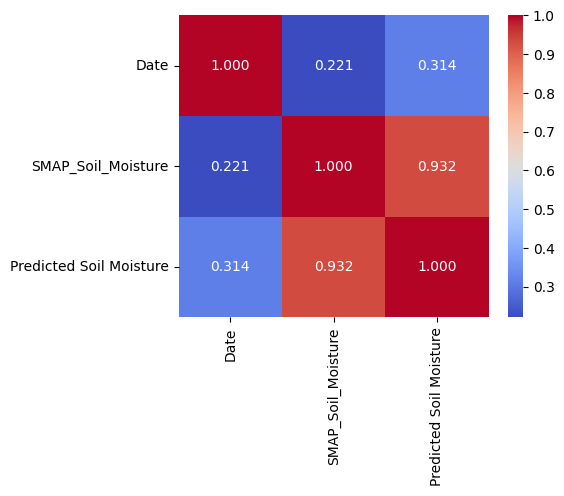

In [47]:
plt.figure(figsize=(5,4),dpi=100)
sns.heatmap(Data_Test.corr(),cmap='coolwarm',fmt=".3f",annot=True)

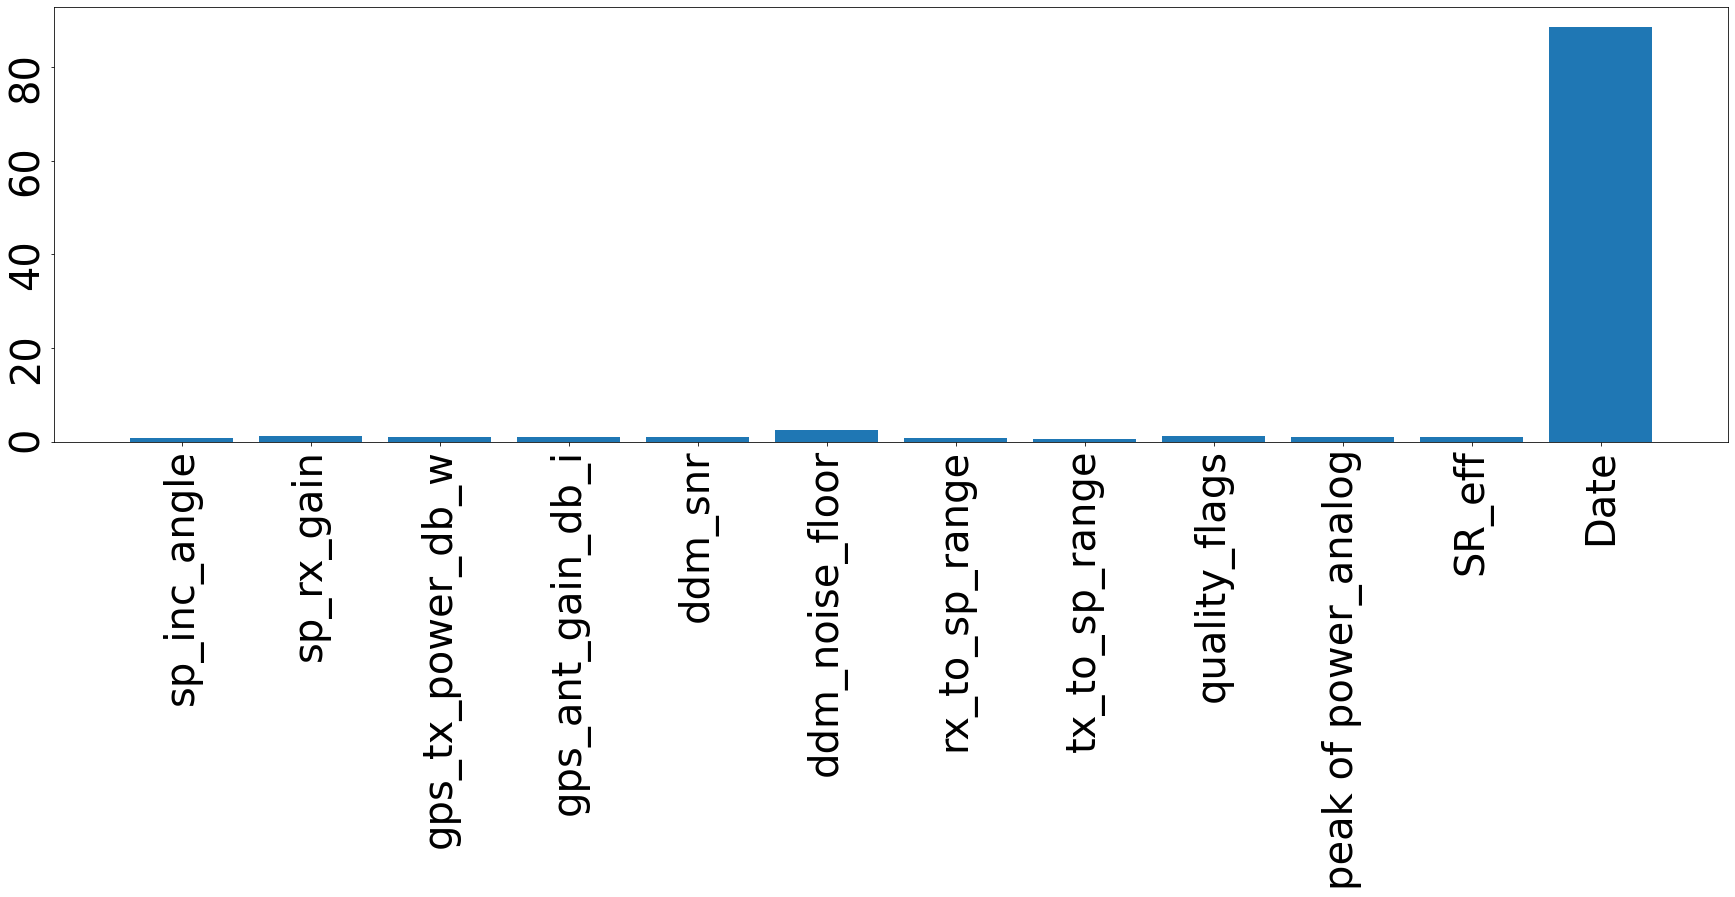

In [48]:
plt.figure(figsize=(30,8))
plt.bar(np.array(Data.iloc[:,:-1].keys()), cat_boost.feature_importances_)
plt.tick_params(axis='both', labelsize=40, rotation =90)

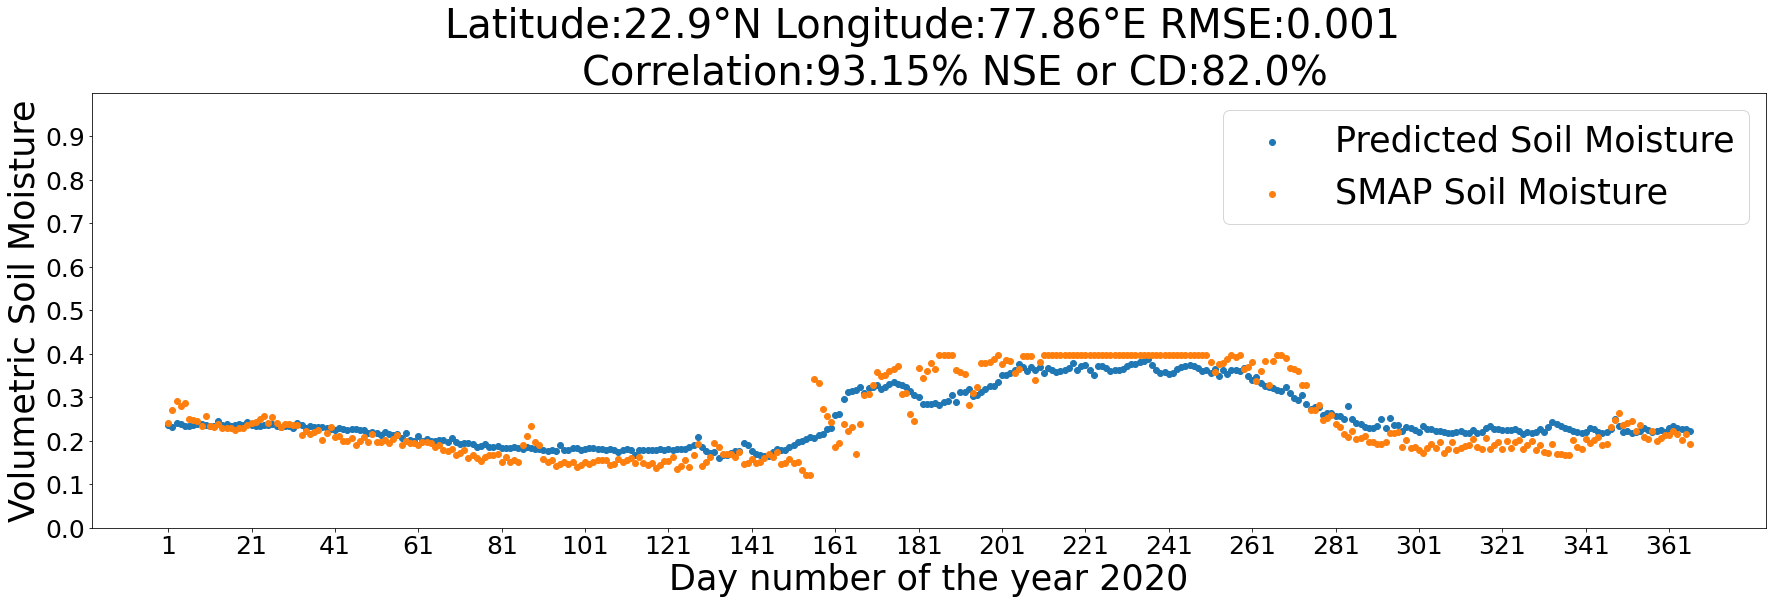

<Figure size 576x576 with 0 Axes>

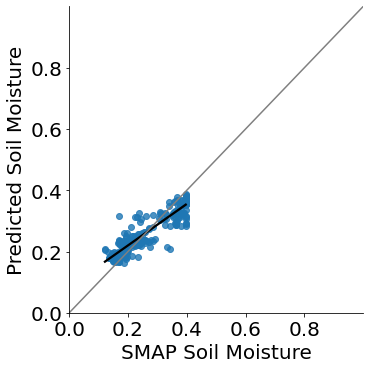

In [49]:
Plotting_Variations(Data_Test,Accuracy_GB)